In [350]:
# Import packages

# Data manipulation
import pandas as pd
import numpy as np
import pandas_datareader as data

# Plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Finance related operations
from pandas_datareader import data as pdf
import yfinance as yfin

# Import this to silence a warning when converting data column of a dataframe on the fly
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tabulate import tabulate

# AC 209A Final Project

## Predicting Stock Variation Using Financial Indicators

**Sabrina Hu and Hamzeh Hamdan**<br/>
**Harvard University**<br/>
**Fall 2022**<br/>

<hr style="height:2.4pt">

<a id='contents'></a>

## Table of Contents

1. [Introduction & Main Objectives](#intro)
2. [Summary of the Data](#summary)
3. [EDA and Data Cleaning](#eda)
4. [Part I: Basic Models](#basic)
    1. [Feature Selection](#feature_selection)
    2. [K-nn & Logistic Regression](#knnlogreg)
    3. [Decision Trees](#dtrees)
    4. [Basic Models Results & Discussion](#basic_results)
5. [Part II: Advanced Models](#advanced)
    1. [Neural Networks](#nn)
    2. [SVM](#svm)
    3. [XGBoost](#xgb)
    4. [Advanced Models Results & Discussion](#adv_results)
6. [Limitations and Future Work](#limitations)

<a id='intro'></a>
## Introduction and Main Objectives
[Return to contents](#contents)

Predicting the movements of stocks over time based on various financial and economic indicators is a common task in the field of finance and investment --- investors and traders rely on these predictions to assess when to buy, sell, and hold stocks, and also to gain a competitive edge in the markets and maximize returns while managing risk. However, predicting the movement of stocks is not an easy task, as prices are constantly fluctuating based on many complex factors like economic indicators, corporate earnings reports, geopolitical events, and market sentiment. In this project, our objective is to understand the relationship between various financial indicators and the increase or decrease in value of a stock. 

The key research questions guiding our project include:
- Which financial indicators are the best predictors of stock price/stock price increase or decrease?
- What type of model can best use financial indicators to classify the increase or decrease of a stock?

The data we will use is the 2018 data from this Kaggle dataset: ‘200+ Financial Indicators of U.S. stocks (2014-2018)’: https://www.kaggle.com/datasets/cnic92/200-financial-indicators-of-us-stocks-20142018?select=2018_Financial_Data.csv

We will first conduct some exploratory data analysis of this dataset before proceeding with the models.

<a id='summary'></a>
## Summary of the Data
[Return to contents](#contents)

First, we load the data as a pandas dataframe and drop rows with no information. We find that the data has 4392 samples and 224 columns. Of these, 222 are numeric, 1 is an int type, and 1 is an object type.

These are:
- 222 numeric: financial indicators
- 1 integer: class column (1 = positive stock price variation, 0 = negative stock price variation)
- 1 object: categorical name of the sector 

In [351]:
# Create a pandas DF of the data, making sure that the stock ticker is the index of the dataframe
df = pd.read_csv('data/2018_Financial_Data.csv', index_col=0)

# Drop rows with no information
df.dropna(how='all', inplace=True)

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4392 entries, CMCSA to ZYME
Columns: 224 entries, Revenue to Class
dtypes: float64(222), int64(1), object(1)
memory usage: 7.5+ MB


In [352]:
# Shape of dataset
print(df.shape)

(4392, 224)


In [353]:
print("Features of the dataset and their data types:")
print(df.dtypes)

Features of the dataset and their data types:
Revenue                 float64
Revenue Growth          float64
Cost of Revenue         float64
Gross Profit            float64
R&D Expenses            float64
                         ...   
R&D Expense Growth      float64
SG&A Expenses Growth    float64
Sector                   object
2019 PRICE VAR [%]      float64
Class                     int64
Length: 224, dtype: object


In [354]:
# Describe dataset variables
df.describe()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,2019 PRICE VAR [%],Class
count,4.346000e+03,4253.000000,4.207000e+03,4.328000e+03,4.155000e+03,4.226000e+03,4.208000e+03,4.357000e+03,4.208000e+03,4.321000e+03,...,4067.000000,4268.000000,4160.000000,4178.000000,4121.000000,4128.000000,4133.000000,4144.000000,4392.000000,4392.000000
mean,5.119287e+09,3.455278,3.144946e+09,2.043954e+09,1.180176e+08,9.005022e+08,1.435546e+09,6.541207e+08,1.001350e+08,5.584432e+08,...,0.006081,36.768524,0.183066,1.389013,0.262530,9.928446,0.091891,0.153610,20.803948,0.693534
std,2.049504e+10,195.504906,1.508813e+10,7.682369e+09,9.330891e+08,3.661116e+09,5.529831e+09,2.969341e+09,3.780021e+08,2.639327e+09,...,0.239653,2347.079237,4.688013,35.123904,5.612666,363.717734,0.823281,0.839647,82.622147,0.461078
min,-6.894100e+07,-3.461500,-2.669055e+09,-1.818220e+09,-1.042000e+08,-1.401594e+08,-4.280000e+09,-1.455700e+10,-1.408252e+09,-2.177200e+10,...,-1.000000,-1.000000,-1.000000,-0.999100,-32.258100,-1.000000,-1.000000,-1.000000,-99.864779,0.000000
25%,6.501425e+07,0.000000,3.415500e+06,3.618903e+07,0.000000e+00,2.056226e+07,4.223644e+07,-5.510000e+06,0.000000e+00,-1.000800e+07,...,0.000000,-0.048075,0.000000,-0.036700,-0.108600,-0.082850,0.000000,-0.004650,-7.477173,0.000000
50%,4.982640e+08,0.074900,1.741180e+08,2.219470e+08,0.000000e+00,9.390450e+07,1.806253e+08,4.203800e+07,5.693500e+06,2.730700e+07,...,0.000000,0.010200,0.000000,0.034750,0.026100,0.000000,0.000000,0.065700,17.639393,1.000000
75%,2.457878e+09,0.188500,1.297814e+09,9.767015e+08,1.450150e+07,4.117162e+08,6.796040e+08,2.862690e+08,5.817075e+07,2.238810e+08,...,0.042050,0.185900,0.080050,0.160575,0.138400,0.115425,0.009700,0.167625,39.625879,1.000000
max,5.003430e+11,12739.000000,3.733960e+11,1.269470e+11,2.883700e+10,1.065100e+11,1.065100e+11,7.089800e+10,9.168000e+09,7.290300e+10,...,4.079100,153332.333300,293.473000,1184.993800,313.395800,17646.823500,36.898100,43.718800,3756.716345,1.000000


<a id='eda'></a>
## Exploratory Data Analysis and Data Cleaning
[Return to contents](#contents)

### Exploratory Data Analysis

First, we will do some exploratory data analysis of our dataset to extract important insights and learn how the variables are related to each other.

We plotted the % price variation for all observations, and also specifically by sector. We also plotted bar graphs of class counts (1 = positive price variation, 0 = negative price variation) and sector counts. Here are some key observations:

- The % Price Var mainly centers around 0, which shows that most stocks do not significantly increase or decrease. This may tell us that the classification problem in this case may be a better problem to pursue than predicting the actual value of the stock variation.
- When plotting the % Price Var by sector, we see that all sectors generally center around 0, which follows the overall trend. However, real estate and utilities are the only sectors where the $ price variation doesn't center around 0, which may indicate that being in those sectors is correlated with positive % price variation.
- The samples are not balanced in terms of class. This is very important and should be accounted for when splitting the data between the training and testing data. We have approximately 3000 stocks of class count 1 (they are buy-worthy stocks that had a positive annual return), and just under 1500 of class count 0 (they are not buy-worthy stocks as they had a negative. annual return).
- The sectors are not equally represented in the data. There are 5 sectors with 500+ stocks and the remanining 6 have less than 300 stocks. Of these, 2 have less than 100 stocks. This should be kept in mind as we choose our model.

We then try to find errors in the data by plotting the annual price variation of each stock in a sector along a graph. Very high values can be errors in data entry or simply inorganic growth in returns. We found that these sectors had at least one stock with over ~500% returns, and likely are not realistic: Consumer Cyclical, Technology, Industrials, Consumer Defensive, and Healthcare. Note that this choice was arbitrary.

There were a total of 8 stocks under this category. For each one, we plotted the daily close value for the year along with the volume. This helps us find out if the gains are organic or are due to an error. We find that of those, DRIO seems to not be organic as the price jumps x8 very quickly, then doubles yet again within a month. We dropped this stock from the data. We also drop the 4 stocks that have been delisted from the data.

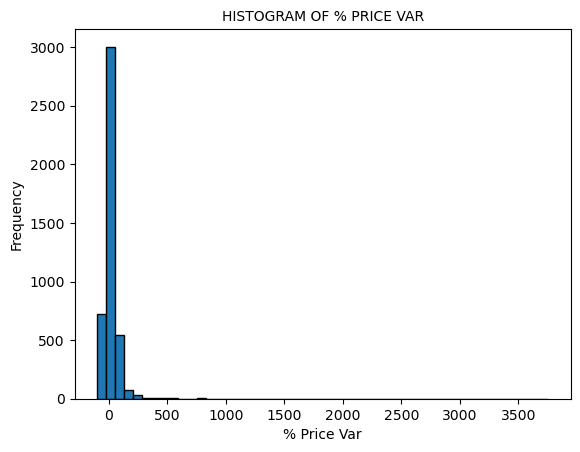

In [355]:
# Plot price variation distribution
plt.hist(df['2019 PRICE VAR [%]'], bins=50, edgecolor='black')
plt.title('HISTOGRAM OF % PRICE VAR', fontsize=10)
plt.xlabel('% Price Var')
plt.ylabel('Frequency')
plt.show()

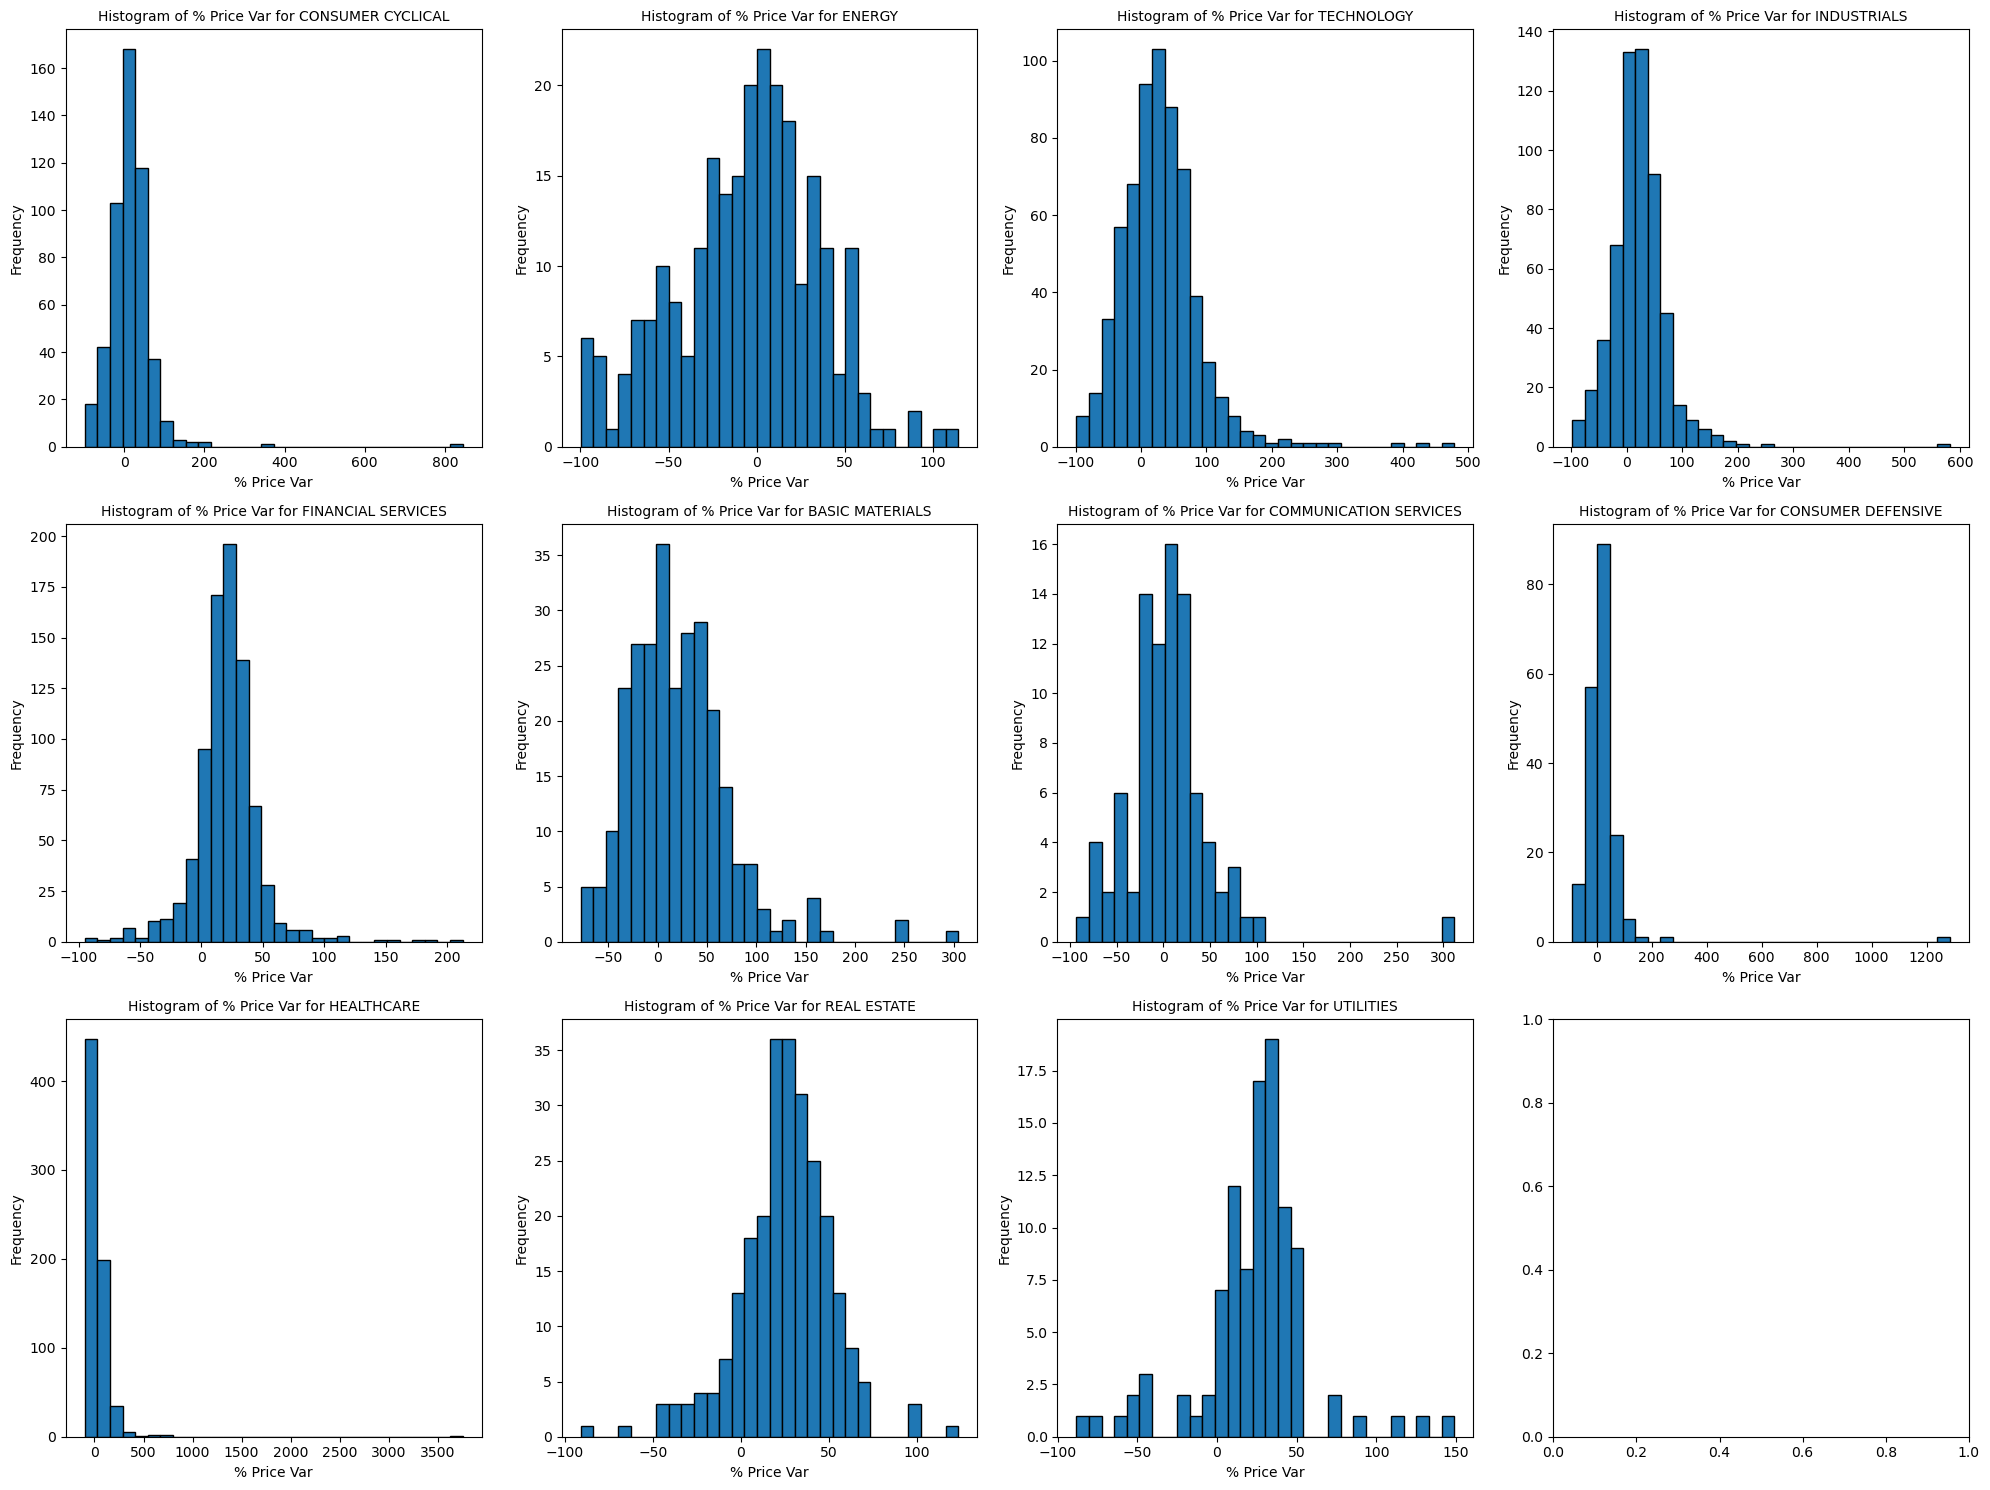

In [356]:
# Extract the columns we need in this step from the dataframe
df_ = df.loc[:, ['Sector', '2019 PRICE VAR [%]']]

# Get list of sectors
sector_list = df_['Sector'].unique()

# Create a 3x4 grid for the histograms
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
axs = axs.ravel()

# Plot the histogram of percent price variation for each sector
for i, sector in enumerate(sector_list):

    temp = df_[df_['Sector'] == sector]

    axs[i].hist(temp['2019 PRICE VAR [%]'], bins=30, edgecolor='black')
    axs[i].set_title('Histogram of % Price Var for ' + sector.upper(), fontsize=10)
    axs[i].set_xlabel('% Price Var')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

/Users/Sabrina/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Sabrina/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Sabrina/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Sabrina/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

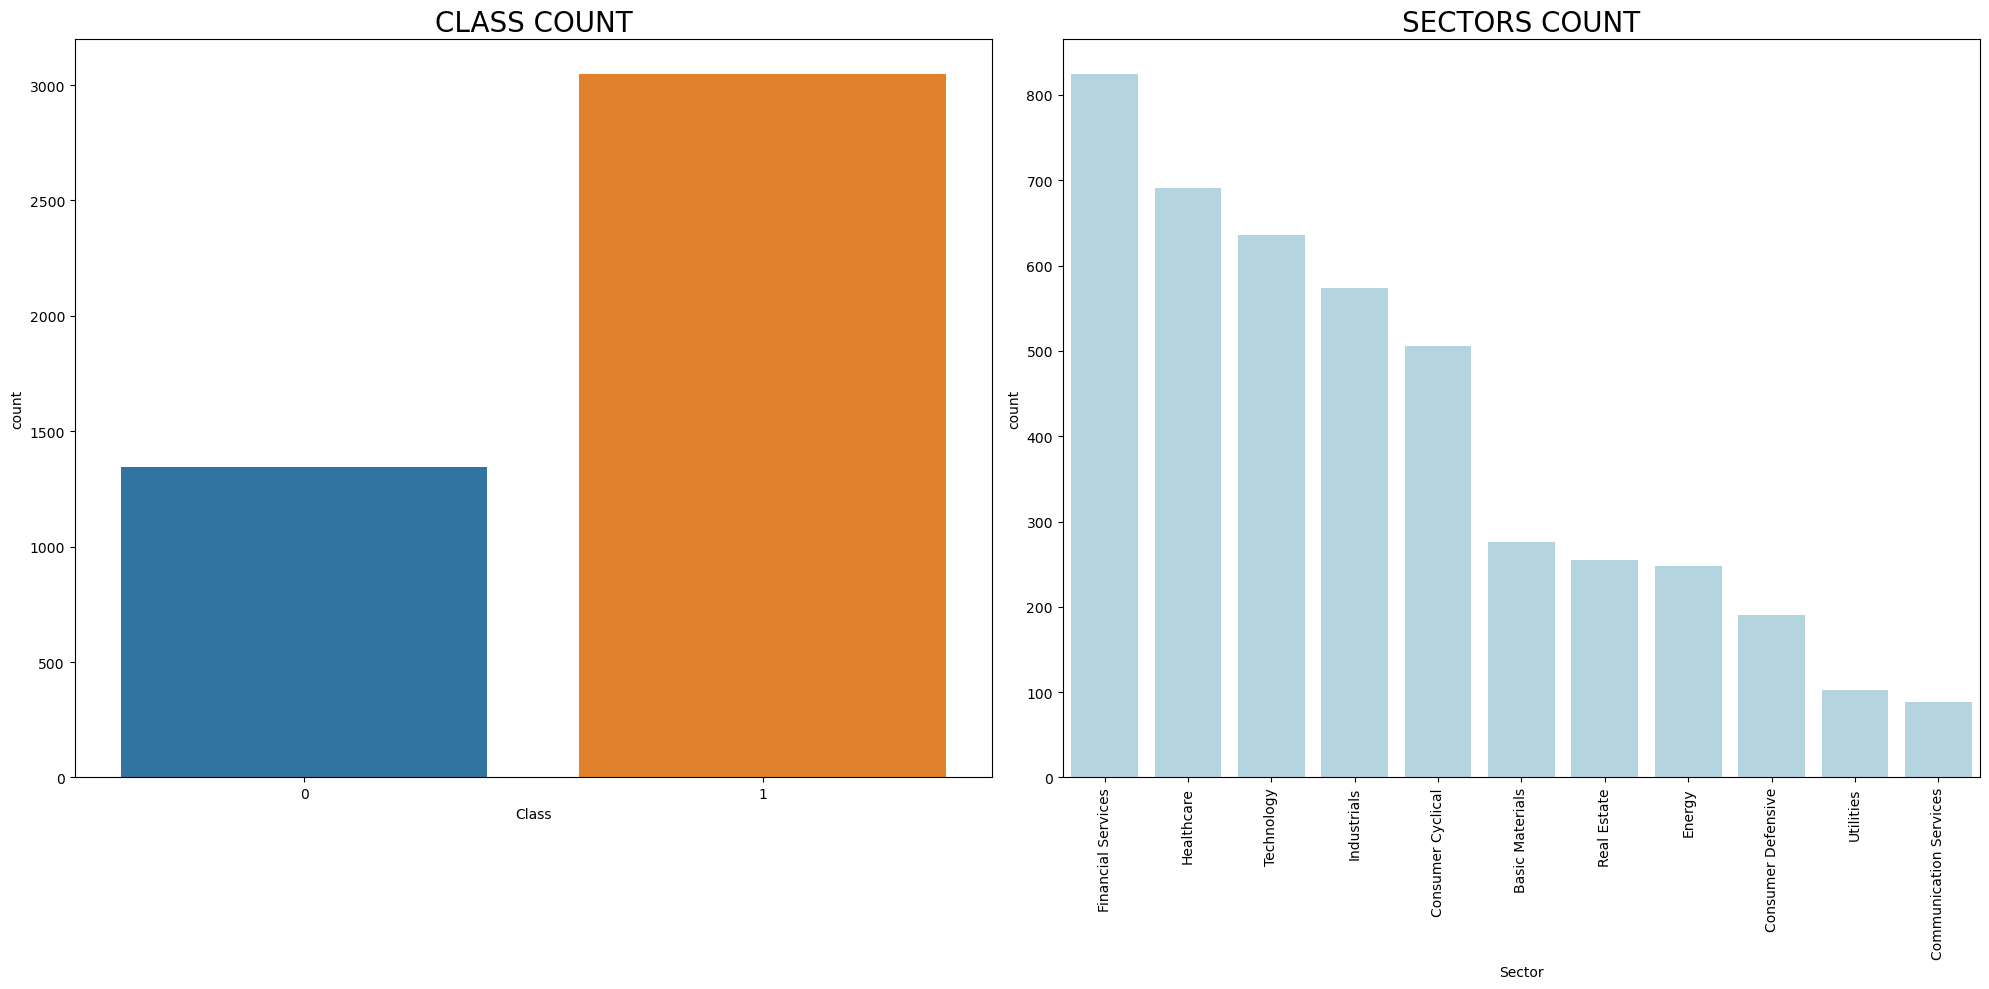

In [357]:
# Create a 1x2 grid for the subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot class distribution
df_class = df['Class'].value_counts()
sns.barplot(x=df_class.index, y=df_class, ax=axs[0])
axs[0].set_title('CLASS COUNT', fontsize=20)

# Plot sector distribution
df_sector = df['Sector'].value_counts()
sns.barplot(x=df_sector.index, y=df_sector, color='lightblue', ax=axs[1])
axs[1].set_xticks(np.arange(len(df_sector)))
axs[1].set_xticklabels(df_sector.index.values.tolist(), rotation=90)
axs[1].set_title('SECTORS COUNT', fontsize=20)

plt.tight_layout()
plt.show()

8 STOCKS with more than 500% gain.
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ANFI']: Exception('%ticker%: No timezone found, symbol may be delisted')



Data not available for ANFI. Skipping plot.
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['SSI']: Exception('%ticker%: No timezone found, symbol may be delisted')



Data not available for SSI. Skipping plot.
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ARQL']: Exception('%ticker%: No timezone found, symbol may be delisted')



Data not available for ARQL. Skipping plot.
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HEBT']: Exception('%ticker%: No timezone found, symbol may be delisted')



Data not available for HEBT. Skipping plot.


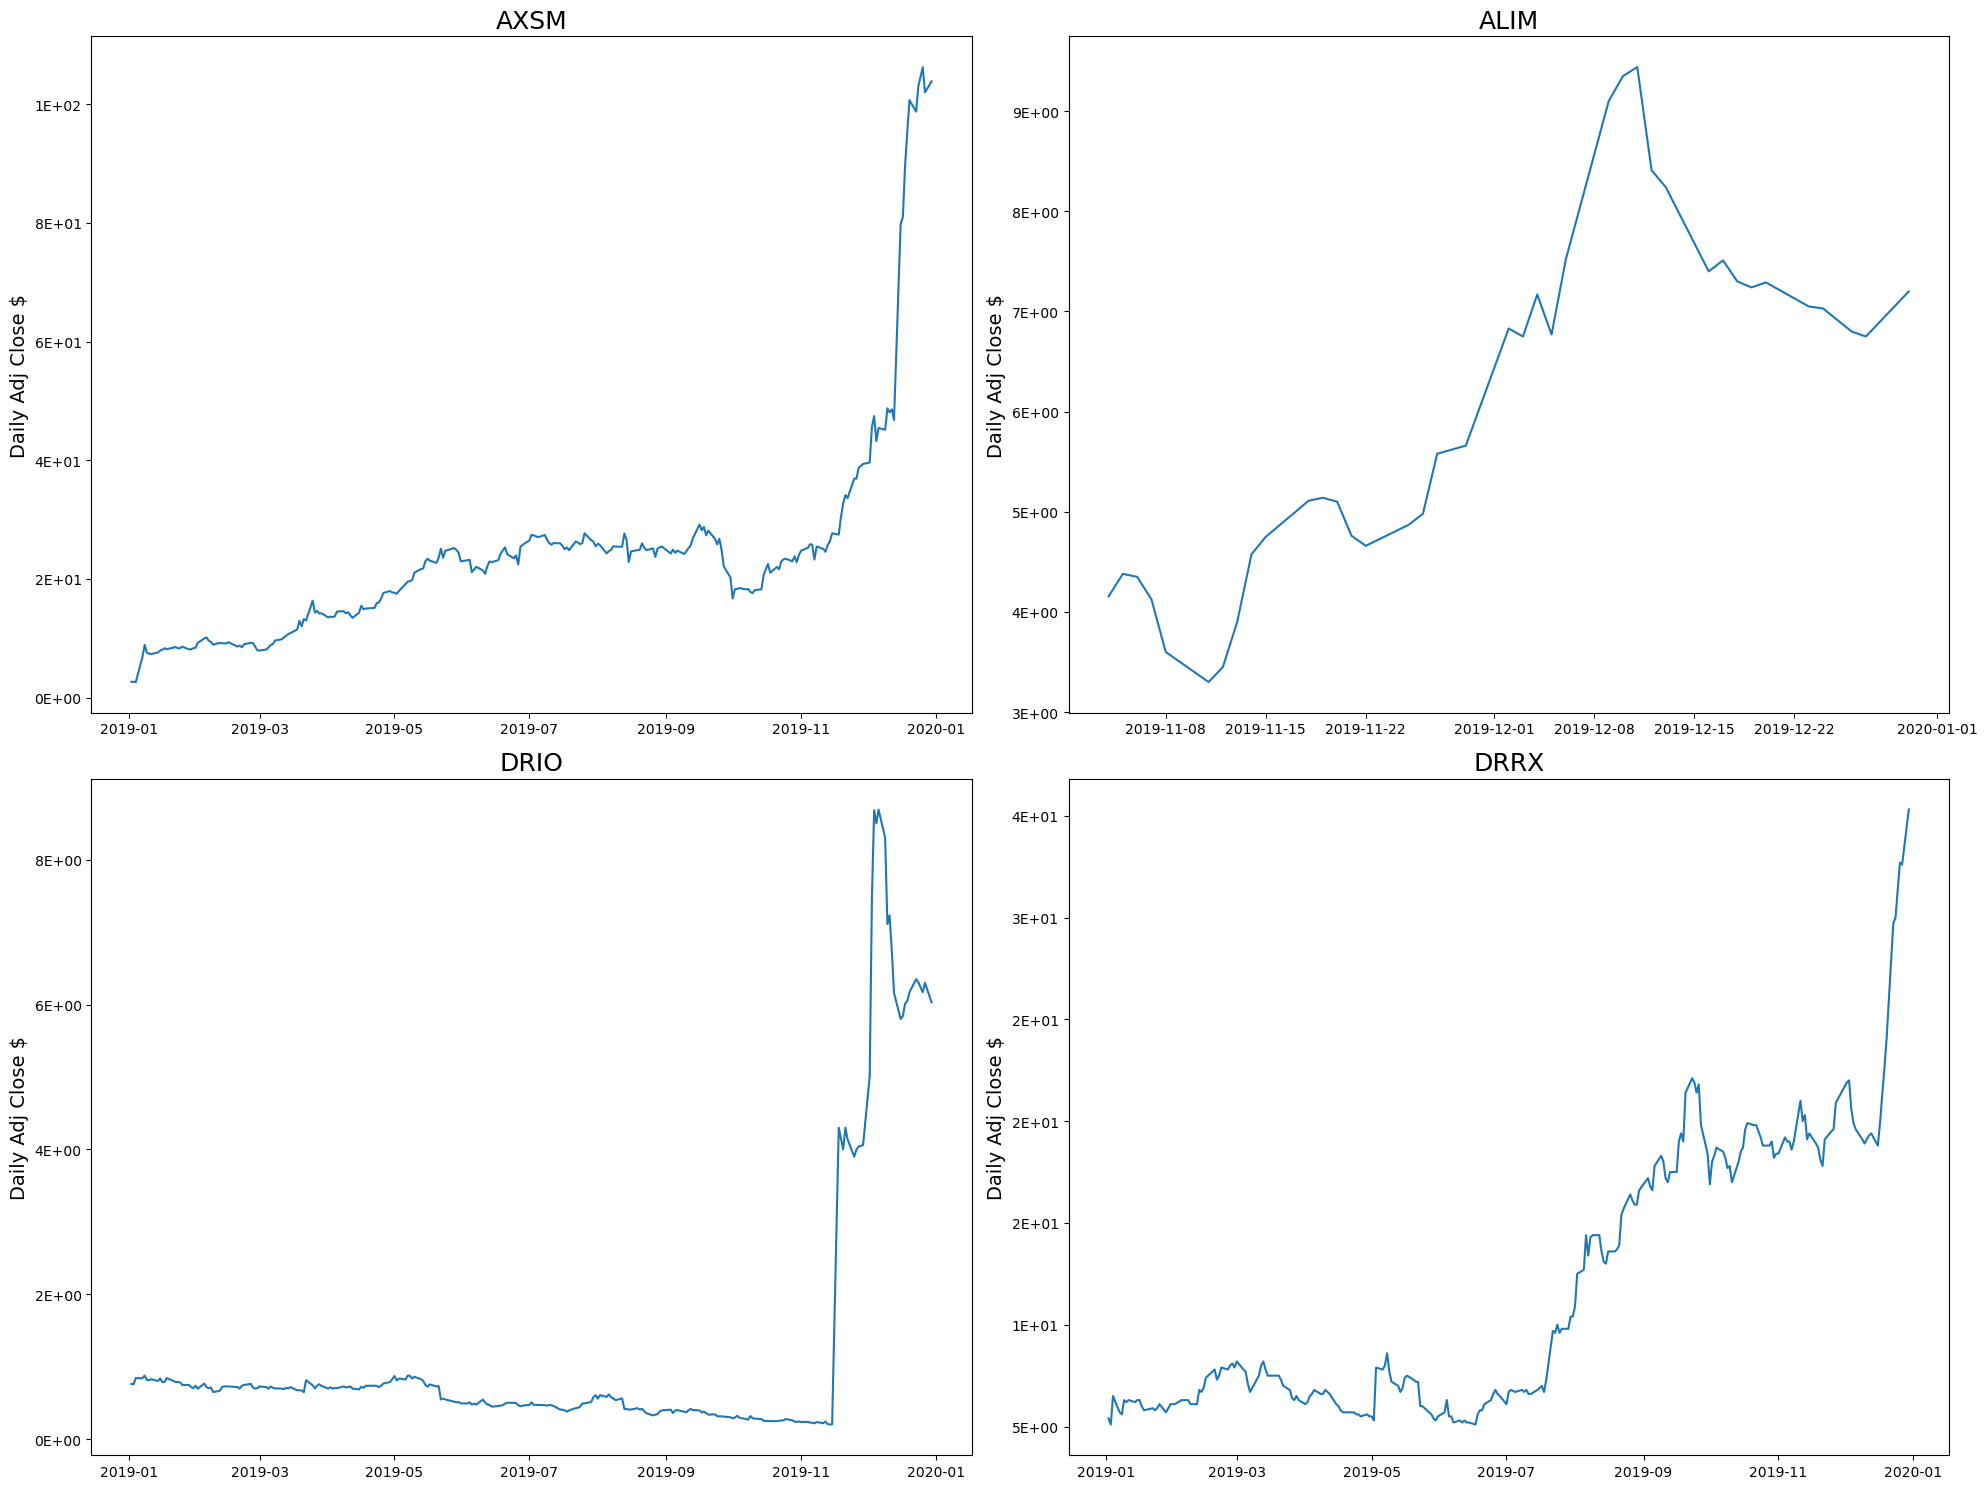

In [358]:
# Get stocks that increased more than 500%
gain = 500
top_gainers = df_[df_['2019 PRICE VAR [%]'] >= gain]
top_gainers = top_gainers['2019 PRICE VAR [%]'].sort_values(ascending=False)
print(f'{len(top_gainers)} STOCKS with more than {gain}% gain.')

# Set
date_start = '2019-01-01'
date_end = '2019-12-31'
tickers = top_gainers.index.values.tolist()

# Create a 2x2 grid for the subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.ravel()

j = 0
for i, ticker in enumerate(tickers):
    try:

        yfin.pdr_override()
        # Pull daily prices for each ticker from Yahoo Finance
        daily_price = pdf.get_data_yahoo(ticker, start=date_start, end=date_end)

        # Check if data download was successful
        if not daily_price.empty:
            # Plot prices with volume
            axs[j].plot(daily_price['Adj Close'])
            axs[j].set_title(ticker, fontsize=18)
            axs[j].set_ylabel('Daily Adj Close $', fontsize=14)
            axs[j].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:.0E}'))
            j += 1

        else:
            print(f"Data not available for {ticker}. Skipping plot.")

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

fig.tight_layout()
plt.show()

In [359]:
delisted_stocks = ['ANFI', 'SSI', 'ARQL', 'HEBT']
df_ = df_.drop(delisted_stocks + ['DRIO'], errors='ignore')

### Data Cleaning - Missing Values

After doing a quick check for missing values, we found that there were many variables with a lot of missing values or 0 values. We plotted this as a percentage and filtered through predictors using this method.

We used an ~6% nan and zeros dominance threshold to drop columns (so that each feature is at most ~6% nan values and at most ~6% zero values). This resulted in dropping the top 50% nan-dominant financial indicators, and the top 40% zero-dominant financial indicators. This resulted in 70 remaining predictors of the 224.

Then, we deleted the top 3 and bottom 3 percentiles of the data in order to account for outliers.

Finally, we imputed missing values with the mean of the column's sector, given the underlying characteristics of the stocks in each sector. This should not have a large impact on our analysis since this was only ~6% of all data in the columns.

In [360]:
missing_values = df.isnull().sum()

missing_df = pd.DataFrame({'Column': missing_values.index, 'Missing Values': missing_values.values})

missing_df = missing_df.sort_values(by='Missing Values', ascending=False)

print(missing_df)

                                         Column  Missing Values
112                         cashConversionCycle            4386
110                              operatingCycle            4386
127                     shortTermCoverageRatios            1926
208  10Y Shareholders Equity Growth (per Share)            1695
82                   priceEarningsToGrowthRatio            1658
..                                          ...             ...
54                  Retained earnings (deficit)              21
70                          Financing Cash Flow              19
221                                      Sector               0
222                          2019 PRICE VAR [%]               0
223                                       Class               0

[224 rows x 2 columns]


From the above, we observe that the two columns with the most missingness are 'cashConversionCycle' and 'operatingCycle', both other which are missing almost all of their values. Although there are many reasons for why certain indicators might be missing so much data, whether it be through data collection methods or the actual companies' records, in this case, it is likely that the indicators with so much missingness are not collected as rigorously for a reason. Thus, it is much more practical to remove these indicators, especially since we have 222 to begin with.

Below, we plotted both the NAN-values and zero-values count for all of the indicators, just to given a picture of how much missingness there is overall in the dataset. We also plotted the indicators with the highest NAN and zero dominance. 

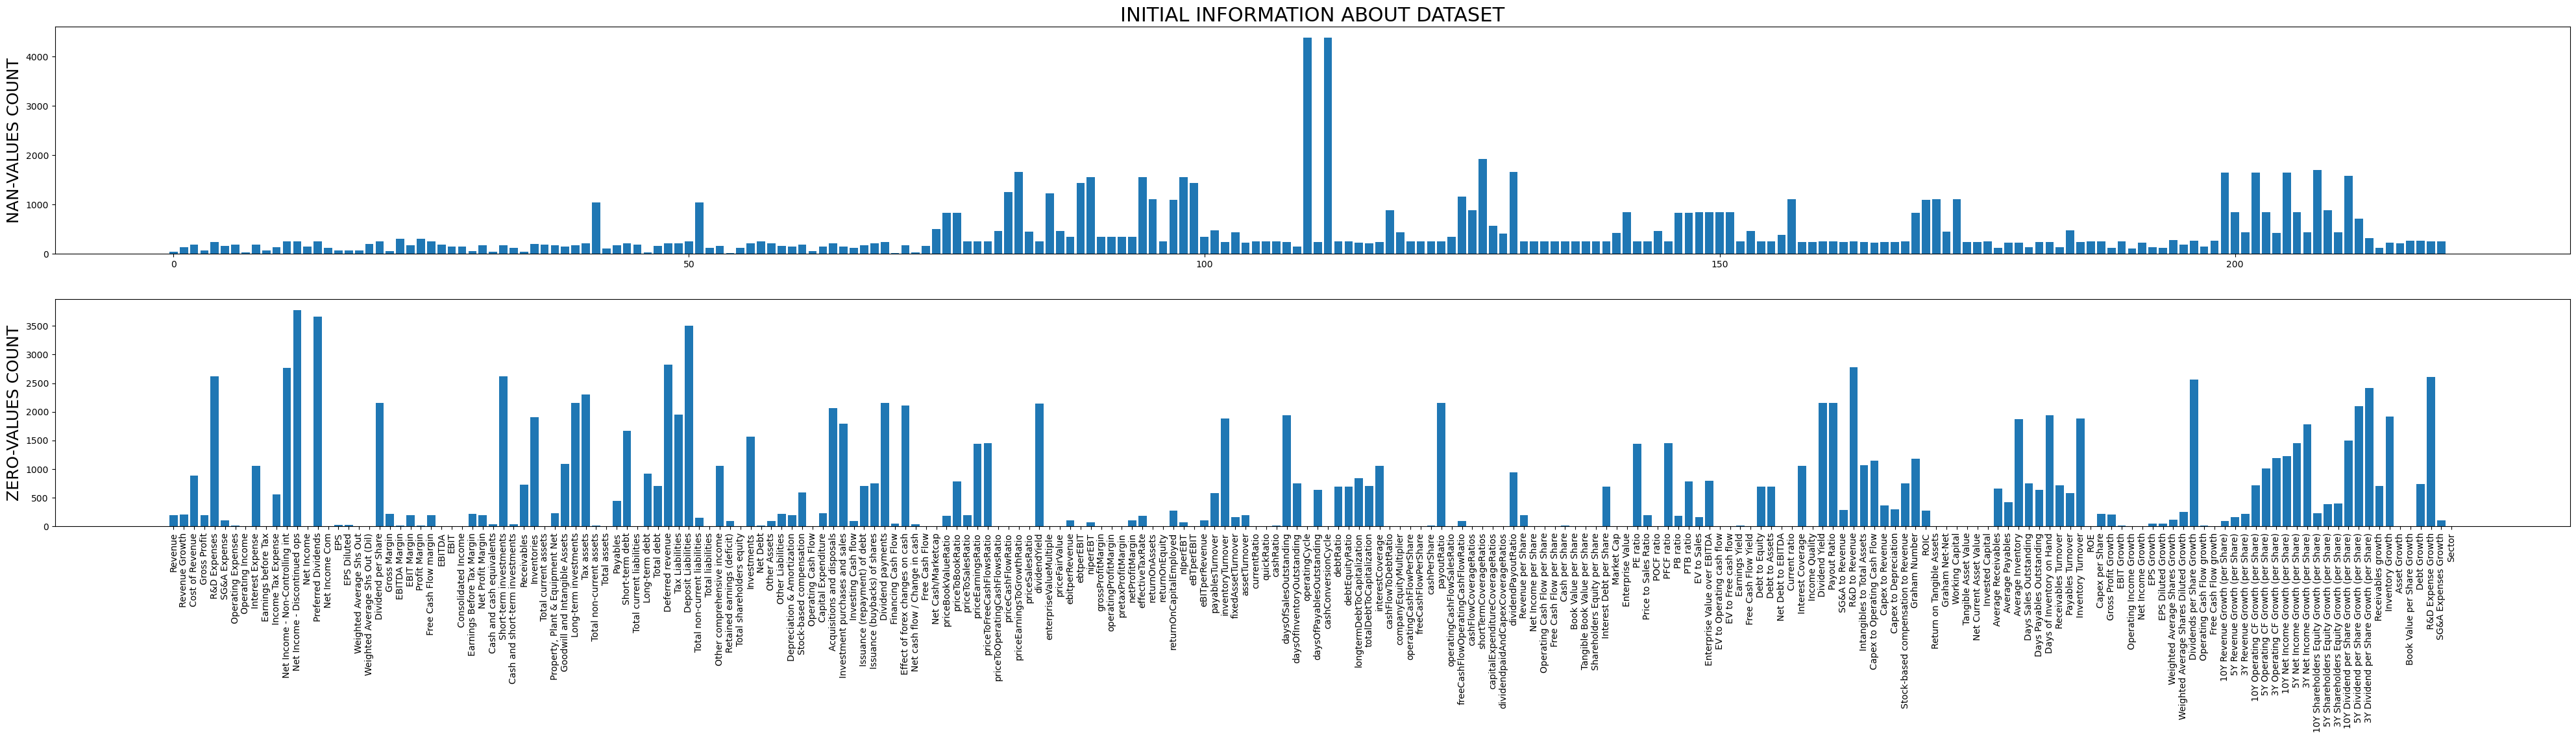

In [361]:
# Drop columns relative to classification, we will use them later
class_data = df.loc[:, ['Class', '2019 PRICE VAR [%]']]
df.drop(['Class', '2019 PRICE VAR [%]'], inplace=True, axis=1)

# Plot initial status of data quality in terms of nan-values and zero-values
nan_vals = df.isna().sum()
zero_vals = df.isin([0]).sum()
ind = np.arange(df.shape[1])

plt.figure(figsize=(50,10))

plt.subplot(2,1,1)
plt.title('INITIAL INFORMATION ABOUT DATASET', fontsize=22)
plt.bar(ind, nan_vals.values.tolist())
plt.ylabel('NAN-VALUES COUNT', fontsize=18)

plt.subplot(2,1,2)
plt.bar(ind, zero_vals.values.tolist())
plt.ylabel('ZERO-VALUES COUNT', fontsize=18)
plt.xticks(ind, nan_vals.index.values, rotation=90)

plt.show()

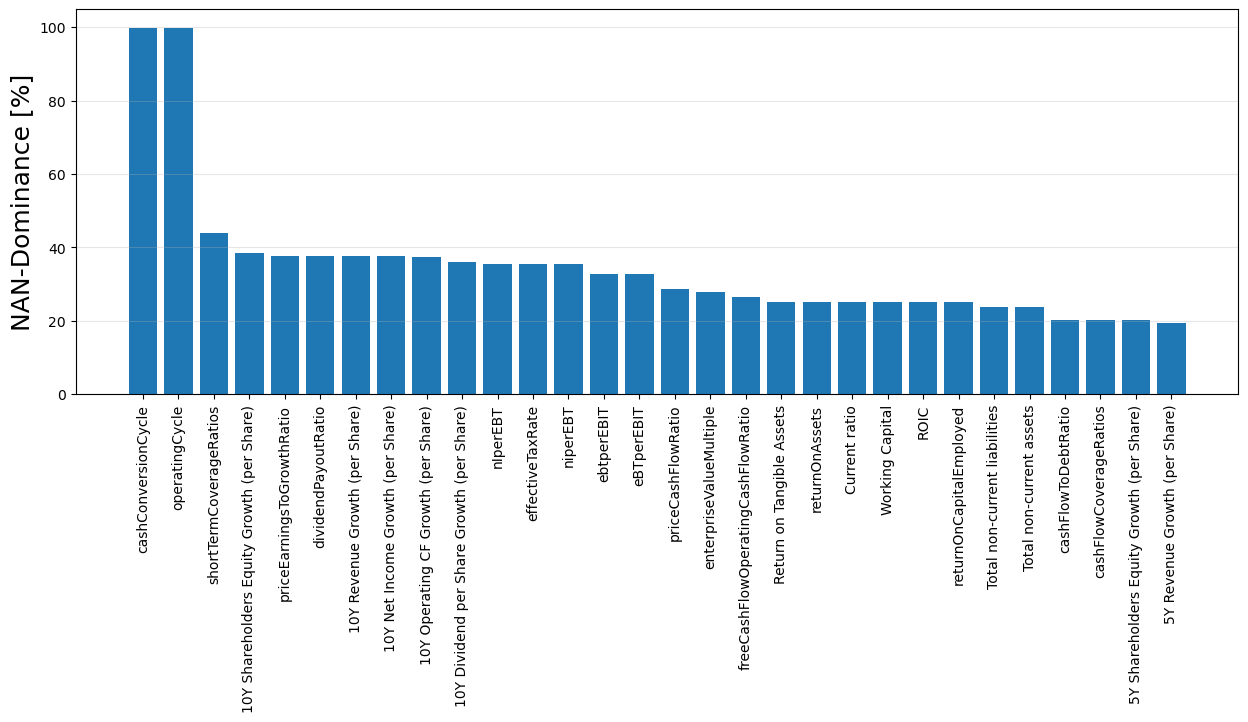

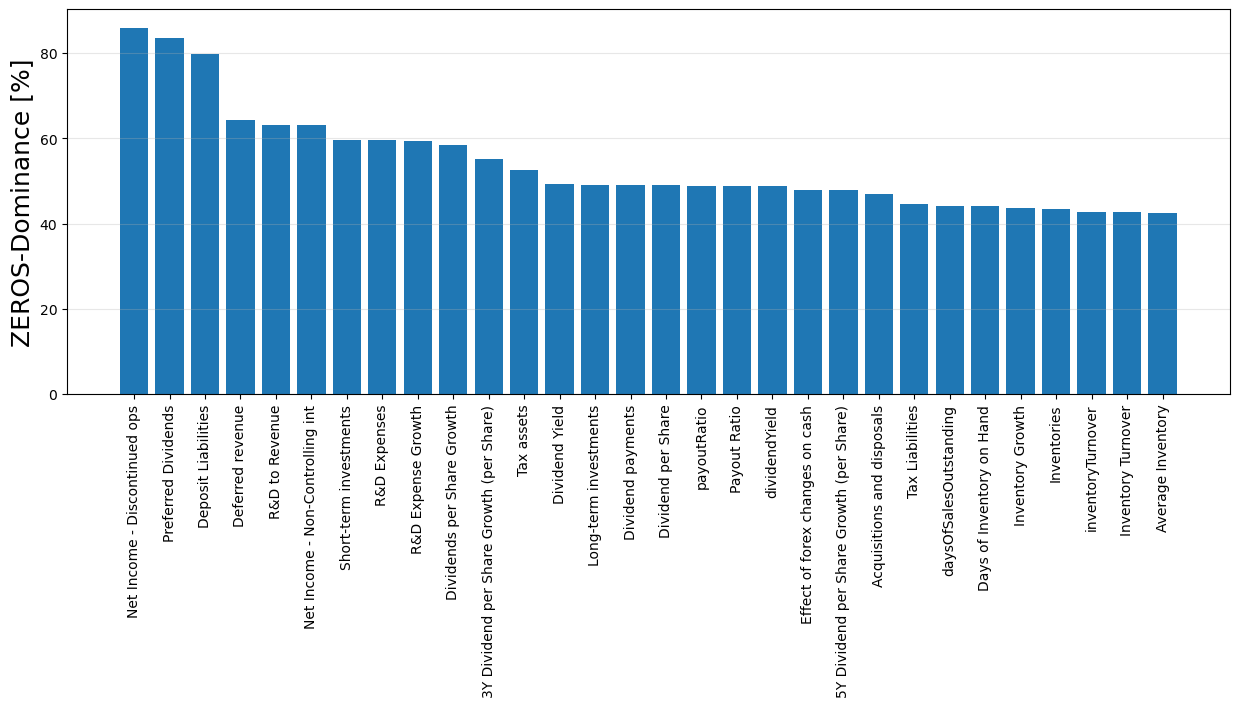

In [362]:
# Find count and percent of nan-values, zero-values
total_nans = df.isnull().sum().sort_values(ascending=False)
percent_nans = (df.isnull().sum()/df.isnull().count() * 100).sort_values(ascending=False)
total_zeros = df.isin([0]).sum().sort_values(ascending=False)
percent_zeros = (df.isin([0]).sum()/df.isin([0]).count() * 100).sort_values(ascending=False)
df_nans = pd.concat([total_nans, percent_nans], axis=1, keys=['Total NaN', 'Percent NaN'])
df_zeros = pd.concat([total_zeros, percent_zeros], axis=1, keys=['Total Zeros', 'Percent Zeros'])

# Graphical representation
plt.figure(figsize=(15,5))
plt.bar(np.arange(30), df_nans['Percent NaN'].iloc[:30].values.tolist())
plt.xticks(np.arange(30), df_nans['Percent NaN'].iloc[:30].index.values.tolist(), rotation=90)
plt.ylabel('NAN-Dominance [%]', fontsize=18)
plt.grid(alpha=0.3, axis='y')
plt.show()

plt.figure(figsize=(15,5))
plt.bar(np.arange(30), df_zeros['Percent Zeros'].iloc[:30].values.tolist())
plt.xticks(np.arange(30), df_zeros['Percent Zeros'].iloc[:30].index.values.tolist(), rotation=90)
plt.ylabel('ZEROS-Dominance [%]', fontsize=18)
plt.grid(alpha=0.3, axis='y')
plt.show()

In [363]:
# Find reasonable threshold for nan-values situation
test_nan_level = 0.5
print(df_nans.quantile(test_nan_level))
_, thresh_nan = df_nans.quantile(test_nan_level)

# Find reasonable threshold for zero-values situation
test_zeros_level = 0.6
print(df_zeros.quantile(test_zeros_level))
_, thresh_zeros = df_zeros.quantile(test_zeros_level)

Total NaN      251.000000
Percent NaN      5.714936
Name: 0.5, dtype: float64
Total Zeros      282.600000
Percent Zeros      6.434426
Name: 0.6, dtype: float64


In [364]:
# Clean dataset applying thresholds for both zero values, nan-values
print(f'INITIAL NUMBER OF VARIABLES: {df.shape[1]}')
print()

df_test1 = df.drop((df_nans[df_nans['Percent NaN'] > thresh_nan]).index, axis=1)
print(f'NUMBER OF VARIABLES AFTER NaN THRESHOLD 6%: {df_test1.shape[1]}')
print()

df_zeros_postnan = df_zeros.drop((df_nans[df_nans['Percent NaN'] > thresh_nan]).index, axis=0)
df_test2 = df_test1.drop((df_zeros_postnan[df_zeros_postnan['Percent Zeros'] > thresh_zeros]).index, axis=1)
print(f'NUMBER OF VARIABLES AFTER Zeros THRESHOLD 6%: {df_test2.shape[1]}')


INITIAL NUMBER OF VARIABLES: 222

NUMBER OF VARIABLES AFTER NaN THRESHOLD 6%: 122

NUMBER OF VARIABLES AFTER Zeros THRESHOLD 6%: 62


In [365]:
# Check our filtered dataset
df_test2.describe()

,Revenue,Revenue Growth,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,EPS,...,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Diluted Growth,Operating Cash Flow growth,Asset Growth,SG&A Expenses Growth
count,4.346000e+03,4253.000000,4.328000e+03,4.226000e+03,4.208000e+03,4.357000e+03,4.321000e+03,4.241000e+03,4.275000e+03,4327.000000,...,4267.000000,4144.000000,4283.000000,4162.000000,4261.000000,4.267000e+03,4210.000000,4250.000000,4178.000000,4144.000000
mean,5.119287e+09,3.455278,2.043954e+09,9.005022e+08,1.435546e+09,6.541207e+08,5.584432e+08,4.473248e+08,4.483776e+08,-69.937477,...,2.085416,-1.687264,0.544211,1.424041,0.551279,9.299665e+03,0.459741,-5.267610,1.389013,0.153610
std,2.049504e+10,195.504906,7.682369e+09,3.661116e+09,5.529831e+09,2.969341e+09,2.639327e+09,2.118659e+09,2.103791e+09,5718.694086,...,212.798494,198.198971,20.218778,62.949132,13.157888,6.074462e+05,10.584789,283.022833,35.123904,0.839647
min,-6.894100e+07,-3.461500,-1.818220e+09,-1.401594e+08,-4.280000e+09,-1.455700e+10,-2.177200e+10,-2.235500e+10,-2.280200e+10,-359825.000000,...,-5536.483300,-12369.000000,-224.200000,-2036.750000,-332.000000,-3.320000e+02,-0.931700,-18001.000000,-0.999100,-1.000000
25%,6.501425e+07,0.000000,3.618903e+07,2.056226e+07,4.223644e+07,-5.510000e+06,-1.000800e+07,-1.065152e+07,-1.108050e+07,-0.390000,...,-0.011750,-0.242875,-0.245650,-0.379725,-0.324800,-3.219500e-01,-0.002575,-0.227675,-0.036700,-0.004650
50%,4.982640e+08,0.074900,2.219470e+08,9.390450e+07,1.806253e+08,4.203800e+07,2.730700e+07,2.365300e+07,2.335100e+07,0.690000,...,0.070800,0.085950,0.075100,0.148250,0.185700,1.863000e-01,0.008800,0.082200,0.034750,0.065700
75%,2.457878e+09,0.188500,9.767015e+08,4.117162e+08,6.796040e+08,2.862690e+08,2.238810e+08,1.962100e+08,1.971180e+08,2.310000,...,0.213300,0.445325,0.381700,0.684250,0.693300,6.905000e-01,0.090700,0.432775,0.160575,0.167625
max,5.003430e+11,12739.000000,1.269470e+11,1.065100e+11,1.065100e+11,7.089800e+10,7.290300e+10,5.953100e+10,5.953100e+10,101641.000000,...,12739.000000,2367.423100,886.989100,3159.000000,395.791700,3.967977e+07,627.712700,239.384600,1184.993800,43.718800


In [366]:
# Filter numeric columns
numeric_columns = df_test2.select_dtypes(include='number').columns

# Cut outliers
top_quantiles = df_test2[numeric_columns].quantile(0.97)
outliers_top = (df_test2[numeric_columns] > top_quantiles)

low_quantiles = df_test2[numeric_columns].quantile(0.03)
outliers_low = (df_test2[numeric_columns] < low_quantiles)

df_test2[numeric_columns] = df_test2[numeric_columns].mask(outliers_top, top_quantiles, axis=1)
df_test2[numeric_columns] = df_test2[numeric_columns].mask(outliers_low, low_quantiles, axis=1)

# Take a look at the dataframe post-outliers cut
df_test2.describe()

,Revenue,Revenue Growth,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,EPS,...,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Diluted Growth,Operating Cash Flow growth,Asset Growth,SG&A Expenses Growth
count,4.346000e+03,4253.000000,4.328000e+03,4.226000e+03,4.208000e+03,4.357000e+03,4.321000e+03,4.241000e+03,4.275000e+03,4327.000000,...,4267.000000,4144.000000,4283.000000,4162.000000,4261.000000,4267.000000,4210.000000,4250.000000,4178.000000,4144.000000
mean,3.437039e+09,0.135876,1.429547e+09,6.077564e+08,9.843496e+08,4.484311e+08,3.723641e+08,3.086147e+08,3.140187e+08,1.034458,...,0.147406,0.146257,0.074244,0.258234,0.261226,0.255111,0.108432,0.203863,0.111765,0.111833
std,7.342150e+09,0.303442,3.264442e+09,1.394325e+09,2.222997e+09,1.102630e+09,9.602493e+08,8.011006e+08,8.173095e+08,2.934576,...,0.403850,1.385822,1.222431,2.033596,1.841161,1.829999,0.265138,1.277640,0.315776,0.215611
min,0.000000e+00,-0.409488,0.000000e+00,8.908962e+05,4.198818e+06,-1.799788e+08,-2.262394e+08,-2.214994e+08,-2.224393e+08,-6.072000,...,-0.618410,-3.750816,-3.593516,-5.409136,-5.000000,-5.000000,-0.073892,-2.887477,-0.374966,-0.229113
25%,6.501425e+07,0.000000,3.618903e+07,2.056226e+07,4.223644e+07,-5.510000e+06,-1.000800e+07,-1.065152e+07,-1.108050e+07,-0.390000,...,-0.011750,-0.242875,-0.245650,-0.379725,-0.324800,-0.321950,-0.002575,-0.227675,-0.036700,-0.004650
50%,4.982640e+08,0.074900,2.219470e+08,9.390450e+07,1.806253e+08,4.203800e+07,2.730700e+07,2.365300e+07,2.335100e+07,0.690000,...,0.070800,0.085950,0.075100,0.148250,0.185700,0.186300,0.008800,0.082200,0.034750,0.065700
75%,2.457878e+09,0.188500,9.767015e+08,4.117162e+08,6.796040e+08,2.862690e+08,2.238810e+08,1.962100e+08,1.971180e+08,2.310000,...,0.213300,0.445325,0.381700,0.684250,0.693300,0.690500,0.090700,0.432775,0.160575,0.167625
max,3.366963e+10,1.248900,1.596702e+10,6.754875e+09,1.091602e+10,5.184200e+09,4.463000e+09,3.741000e+09,3.812582e+09,8.785400,...,1.631718,4.491038,3.719290,7.155169,6.343560,6.250714,1.225250,4.595985,1.234026,0.811407


In [367]:
# Replace nan-values with mean value of column's sector
for column in df_test2.select_dtypes(include=[np.number]).columns:
    df_test2[column] = df_test2.groupby('Sector')[column].transform(lambda x: x.fillna(x.mean()))

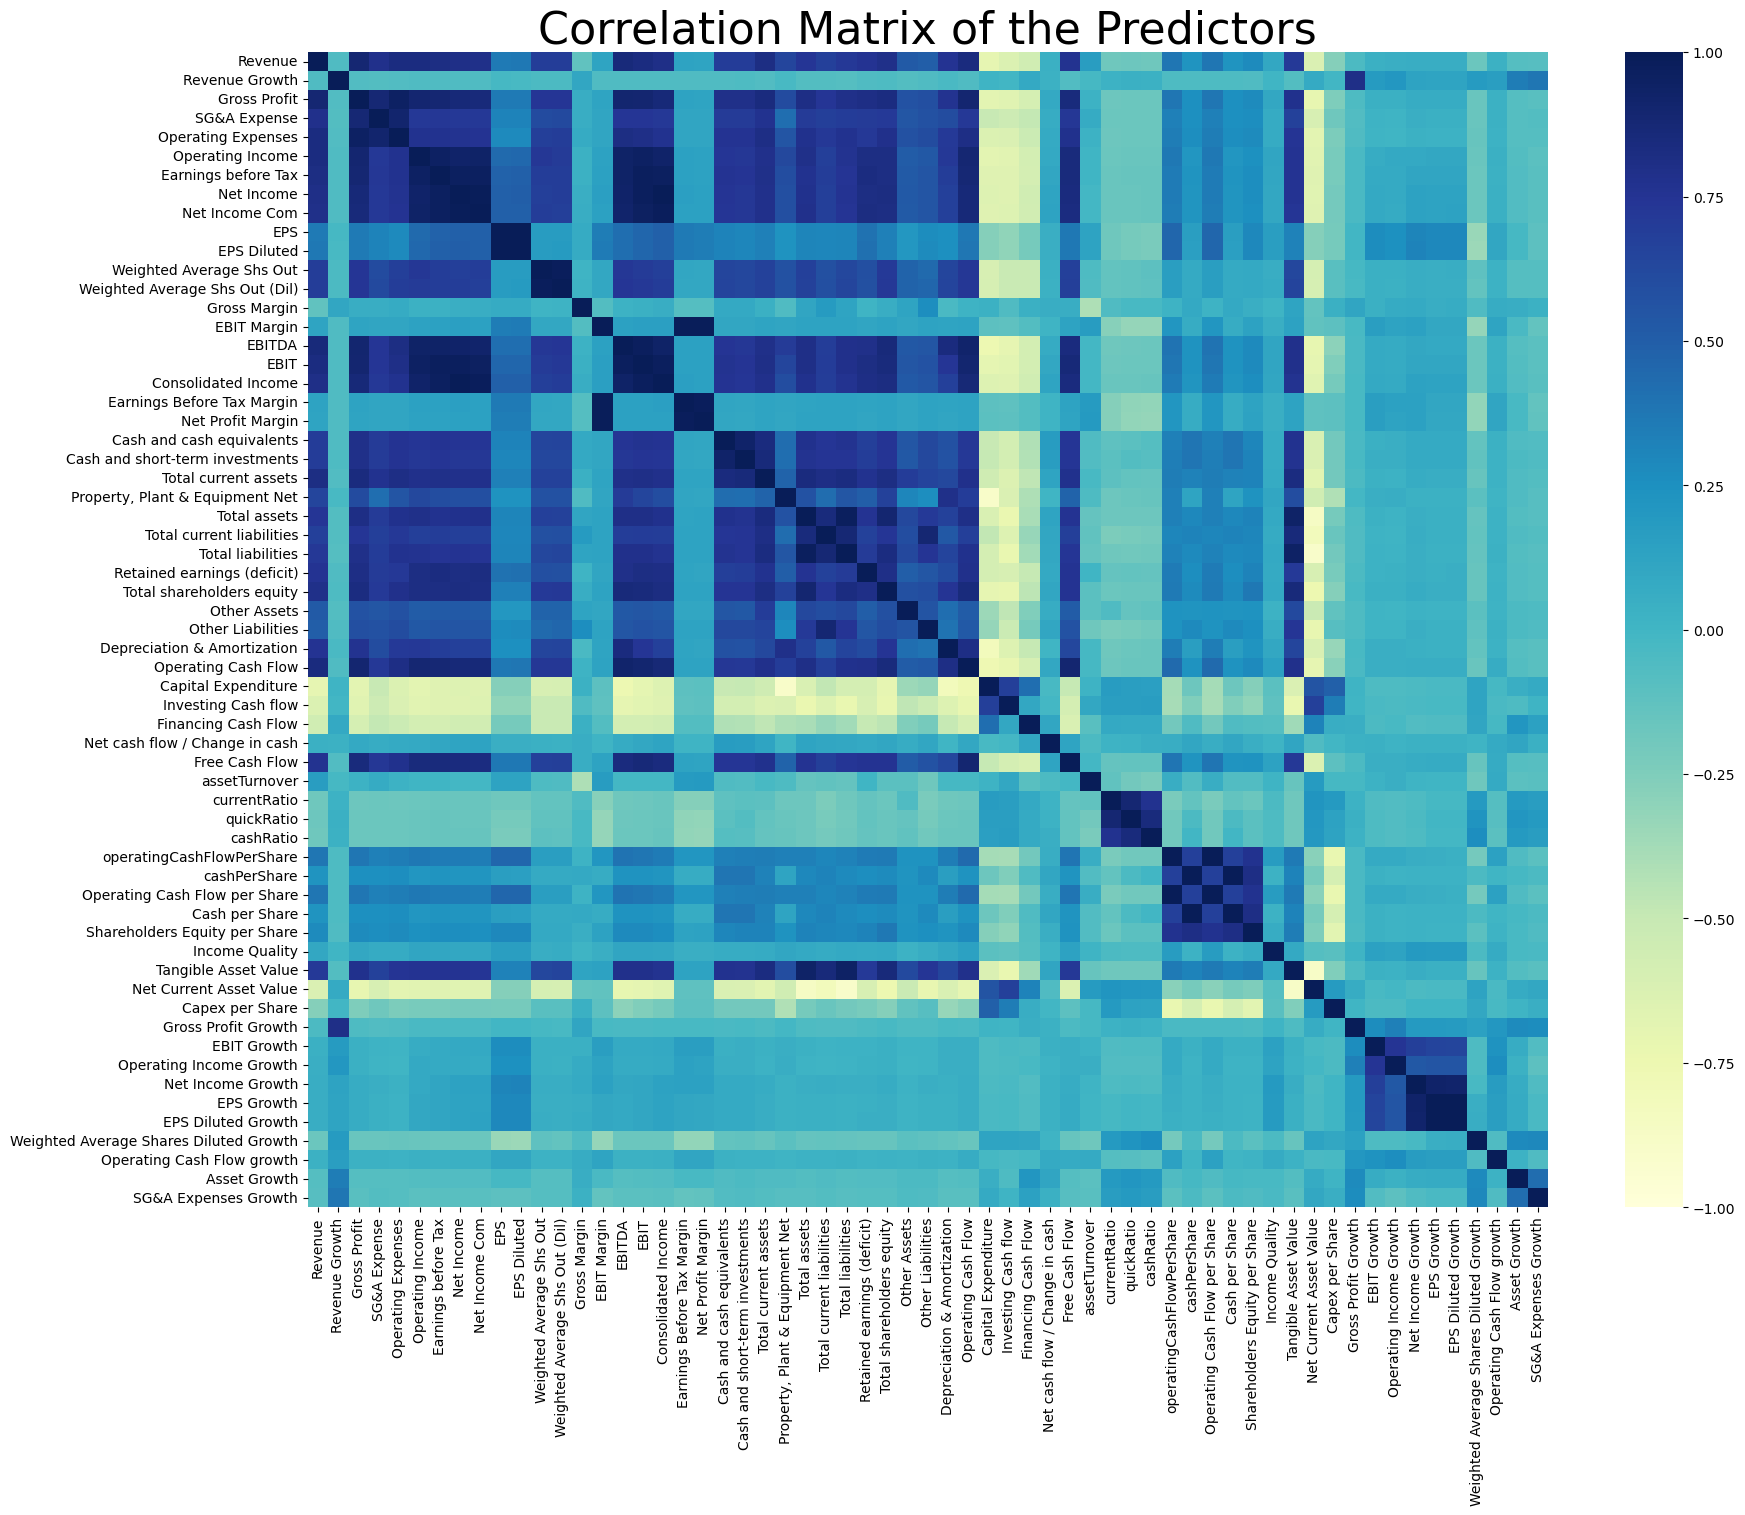

In [368]:
# Plot correlation matrix of output dataset
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df_test2.select_dtypes(include=[np.number]).corr(), annot=False, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax)
plt.title("Correlation Matrix of the Predictors", fontsize=32)
plt.show()

We outputted a correlation matrix of the indicators left, just to give a better sense of the relationships between the various indicators.

In [369]:
# Add the sector column
df_out = df_test2.join(df['Sector'], rsuffix='_right')

# Add back the classification columns
df_out = df_out.join(class_data)

# Print information about dataset
df_out.info()
df_out.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 4392 entries, CMCSA to ZYME
Data columns (total 65 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Revenue                                 4392 non-null   float64
 1   Revenue Growth                          4392 non-null   float64
 2   Gross Profit                            4392 non-null   float64
 3   SG&A Expense                            4392 non-null   float64
 4   Operating Expenses                      4392 non-null   float64
 5   Operating Income                        4392 non-null   float64
 6   Earnings before Tax                     4392 non-null   float64
 7   Net Income                              4392 non-null   float64
 8   Net Income Com                          4392 non-null   float64
 9   EPS                                     4392 non-null   float64
 10  EPS Diluted                             4392 non-null   float

,Revenue,Revenue Growth,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,EPS,...,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Diluted Growth,Operating Cash Flow growth,Asset Growth,SG&A Expenses Growth,Class,2019 PRICE VAR [%]
count,4.392000e+03,4392.000000,4.392000e+03,4.392000e+03,4.392000e+03,4.392000e+03,4.392000e+03,4.392000e+03,4.392000e+03,4392.000000,...,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000
mean,3.431959e+09,0.135713,1.429657e+09,6.163775e+08,9.916391e+08,4.489758e+08,3.731335e+08,3.120485e+08,3.171267e+08,1.041199,...,0.075624,0.267142,0.261734,0.255610,0.107855,0.205875,0.110839,0.110807,0.693534,20.803948
std,7.304752e+09,0.298810,3.241932e+09,1.368804e+09,2.177880e+09,1.098418e+09,9.526861e+08,7.875406e+08,8.066353e+08,2.914112,...,1.207550,1.980463,1.813650,1.803908,0.259936,1.257163,0.308045,0.209506,0.461078,82.622147
min,0.000000e+00,-0.409488,0.000000e+00,8.908962e+05,4.198818e+06,-1.799788e+08,-2.262394e+08,-2.214994e+08,-2.224393e+08,-6.072000,...,-3.593516,-5.409136,-5.000000,-5.000000,-0.073892,-2.887477,-0.374966,-0.229113,0.000000,-99.864779
25%,6.584545e+07,0.000000,3.737700e+07,2.170000e+07,4.624375e+07,-5.199308e+06,-9.525389e+06,-9.446438e+06,-1.041550e+07,-0.372250,...,-0.230650,-0.330750,-0.293425,-0.290675,-0.001400,-0.211250,-0.032200,0.000000,0.000000,-7.477173
50%,5.200504e+08,0.078492,2.384675e+08,1.040695e+08,2.017610e+08,4.366150e+07,2.967350e+07,2.867850e+07,2.708496e+07,0.720000,...,0.080700,0.183050,0.198759,0.197900,0.010900,0.099300,0.042850,0.073350,1.000000,17.639393
75%,2.577958e+09,0.184950,1.025554e+09,5.037902e+08,7.931652e+08,2.963250e+08,2.397000e+08,2.479838e+08,2.345292e+08,2.280000,...,0.375725,0.637225,0.670825,0.673200,0.094068,0.420825,0.147400,0.156400,1.000000,39.625879
max,3.366963e+10,1.248900,1.596702e+10,6.754875e+09,1.091602e+10,5.184200e+09,4.463000e+09,3.741000e+09,3.812582e+09,8.785400,...,3.719290,7.155169,6.343560,6.250714,1.225250,4.595985,1.234026,0.811407,1.000000,3756.716345


In [370]:
print(df_out.columns)
print(len(df_out.columns))

Index(['Revenue', 'Revenue Growth', 'Gross Profit', 'SG&A Expense',
       'Operating Expenses', 'Operating Income', 'Earnings before Tax',
       'Net Income', 'Net Income Com', 'EPS', 'EPS Diluted',
       'Weighted Average Shs Out', 'Weighted Average Shs Out (Dil)',
       'Gross Margin', 'EBIT Margin', 'EBITDA', 'EBIT', 'Consolidated Income',
       'Earnings Before Tax Margin', 'Net Profit Margin',
       'Cash and cash equivalents', 'Cash and short-term investments',
       'Total current assets', 'Property, Plant & Equipment Net',
       'Total assets', 'Total current liabilities', 'Total liabilities',
       'Retained earnings (deficit)', 'Total shareholders equity',
       'Other Assets', 'Other Liabilities', 'Depreciation & Amortization',
       'Operating Cash Flow', 'Capital Expenditure', 'Investing Cash flow',
       'Financing Cash Flow', 'Net cash flow / Change in cash',
       'Free Cash Flow', 'assetTurnover', 'currentRatio', 'quickRatio',
       'cashRatio', 'operatin

Here, we use SMOTE to oversample and balance our classes --- SMOTE is an improved alternative to oversampling, which finds points that are closer in feature space, drawing a line between these points, and generating new data points along the line. We see from the plot that this new dataset, 'df_out_balanced', is balanced now. We will also run all of our models with the original dataset, in case SMOTE introduces too much noise.

In [371]:
df_out2 = df_out.drop(['Sector', 'Sector_right'], axis=1)

In [372]:
# SMOTE oversampling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(df_out2.drop('Class', axis=1), df_out2['Class'])
df_out2 = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res, columns=['Class'])], axis=1)

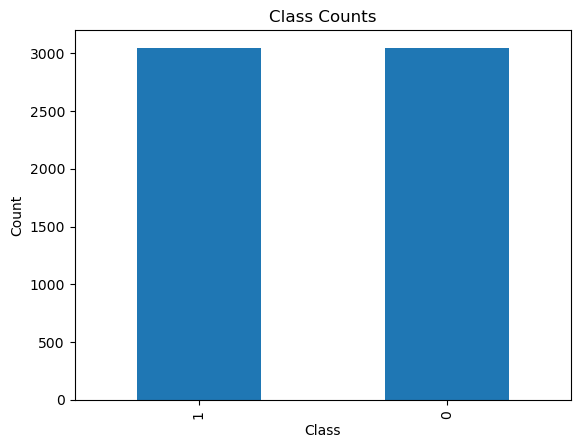

In [373]:
df_out2['Class'].value_counts().plot(kind='bar')
plt.title('Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [374]:
# Undersampling
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(df_out.drop('Class', axis=1), df_out['Class'])
df_out3 = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res, columns=['Class'])], axis=1)

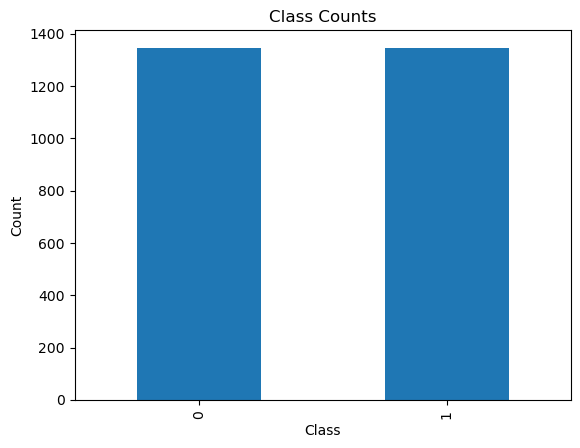

In [375]:
df_out3['Class'].value_counts().plot(kind='bar')
plt.title('Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [376]:
df_out3 = df_out3.drop(['Sector', 'Sector_right'], axis=1)

In [377]:
print(df_out.shape)
print(df_out2.shape)
print(df_out3.shape)

(4392, 65)
(6092, 63)
(2692, 63)


<a id='basic'></a>
## Part I: Basic Models
[Return to contents](#contents)

The main modelling question we are trying to solve is predicting the classification of a stock with its financial indicators (aka whether or not a stock price increased or decreased). First, we will do feature selection, and then we test 2 main basic models, knn/logistic regression and decision trees. Within these models, we will do fine-tuning as well as use various methods to identify feature importance.

<a id='feature'></a>
### Feature Selection
[Return to contents](#contents)

After taking care of data missingness and outliers, we are left with 63 columns, out of which 61 are financial indicators (and thus predictors). However, many of these predictors are highly correlated, so we further cut the number of predictors using feature selection, in all three of our dataframes (undersampling, oversampling, and original). To do this, we grouped features by features that are correlated by more than 0.90, and kept only one feature out of each of these groups to reduce redundancy. This left us with 41 predictors. 

In [378]:
# Select only numeric columns for correlation matrix
numeric_df_out = df_out.select_dtypes(include=[np.number])
numeric_df_out2 = df_out2.select_dtypes(include=[np.number])
numeric_df_out3 = df_out3.select_dtypes(include=[np.number])

# Create correlation matrix for each dataframe
correlation_matrix = numeric_df_out.corr().abs()
correlation_matrix2 = numeric_df_out2.corr().abs()
correlation_matrix3 = numeric_df_out3.corr().abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
upper2 = correlation_matrix2.where(np.triu(np.ones(correlation_matrix2.shape), k=1).astype(bool))
upper3 = correlation_matrix3.where(np.triu(np.ones(correlation_matrix3.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
to_drop2 = [column for column in upper2.columns if any(upper2[column] > 0.90)]
to_drop3 = [column for column in upper3.columns if any(upper3[column] > 0.90)]

# Keep one feature from each group of highly correlated features
for group in to_drop:
    if isinstance(group, list):
        group.remove(group[0])
for group in to_drop2:
    if isinstance(group, list):
        group.remove(group[0])
for group in to_drop3:
    if isinstance(group, list):
        group.remove(group[0])

# Drop the remaining highly correlated features from each dataframe
df_out = df_out.drop(df_out[to_drop], axis=1)
df_out2 = df_out2.drop(df_out2[to_drop2], axis=1)
df_out3 = df_out3.drop(df_out3[to_drop3], axis=1)

In [379]:
# For original dataframe:
for column in to_drop:
    correlated = upper[upper[column] > 0.90].index.tolist()
    print(f"For df_out, dropped {column}, which was highly correlated with: {correlated}")

For df_out, dropped Operating Expenses, which was highly correlated with: ['Gross Profit', 'SG&A Expense']
For df_out, dropped Earnings before Tax, which was highly correlated with: ['Operating Income']
For df_out, dropped Net Income, which was highly correlated with: ['Operating Income', 'Earnings before Tax']
For df_out, dropped Net Income Com, which was highly correlated with: ['Operating Income', 'Earnings before Tax', 'Net Income']
For df_out, dropped EPS Diluted, which was highly correlated with: ['EPS']
For df_out, dropped Weighted Average Shs Out (Dil), which was highly correlated with: ['Weighted Average Shs Out']
For df_out, dropped EBITDA, which was highly correlated with: ['Gross Profit', 'Operating Income', 'Earnings before Tax', 'Net Income', 'Net Income Com']
For df_out, dropped EBIT, which was highly correlated with: ['Operating Income', 'Earnings before Tax', 'Net Income', 'Net Income Com', 'EBITDA']
For df_out, dropped Consolidated Income, which was highly correlated 

In [380]:
print(df_out.columns)
print(len(df_out.columns))

Index(['Revenue', 'Revenue Growth', 'Gross Profit', 'SG&A Expense',
       'Operating Income', 'EPS', 'Weighted Average Shs Out', 'Gross Margin',
       'EBIT Margin', 'Cash and cash equivalents', 'Total current assets',
       'Property, Plant & Equipment Net', 'Total assets',
       'Total current liabilities', 'Retained earnings (deficit)',
       'Total shareholders equity', 'Other Assets', 'Other Liabilities',
       'Depreciation & Amortization', 'Capital Expenditure',
       'Investing Cash flow', 'Financing Cash Flow',
       'Net cash flow / Change in cash', 'Free Cash Flow', 'assetTurnover',
       'currentRatio', 'quickRatio', 'cashRatio', 'operatingCashFlowPerShare',
       'cashPerShare', 'Shareholders Equity per Share', 'Income Quality',
       'Capex per Share', 'Gross Profit Growth', 'EBIT Growth',
       'Operating Income Growth', 'Net Income Growth',
       'Weighted Average Shares Diluted Growth', 'Operating Cash Flow growth',
       'Asset Growth', 'SG&A Expenses Gr

In [381]:
#features = ['Revenue', 'Revenue Growth', 'Operating Income', 'EPS', 'Gross Margin', 'EBIT Margin', 'Total current assets', 'Total current liabilities', 'Total shareholders equity', 'Investing Cash flow', 'Free Cash Flow', 'currentRatio', 'Shareholders Equity per Share', 'Gross Profit Growth', 'EBIT Growth', 'Operating Cash Flow growth']
features = [col for col in df_out.columns if col not in ['Sector', 'Sector_right', 'Class', '2019 PRICE VAR [%]']]

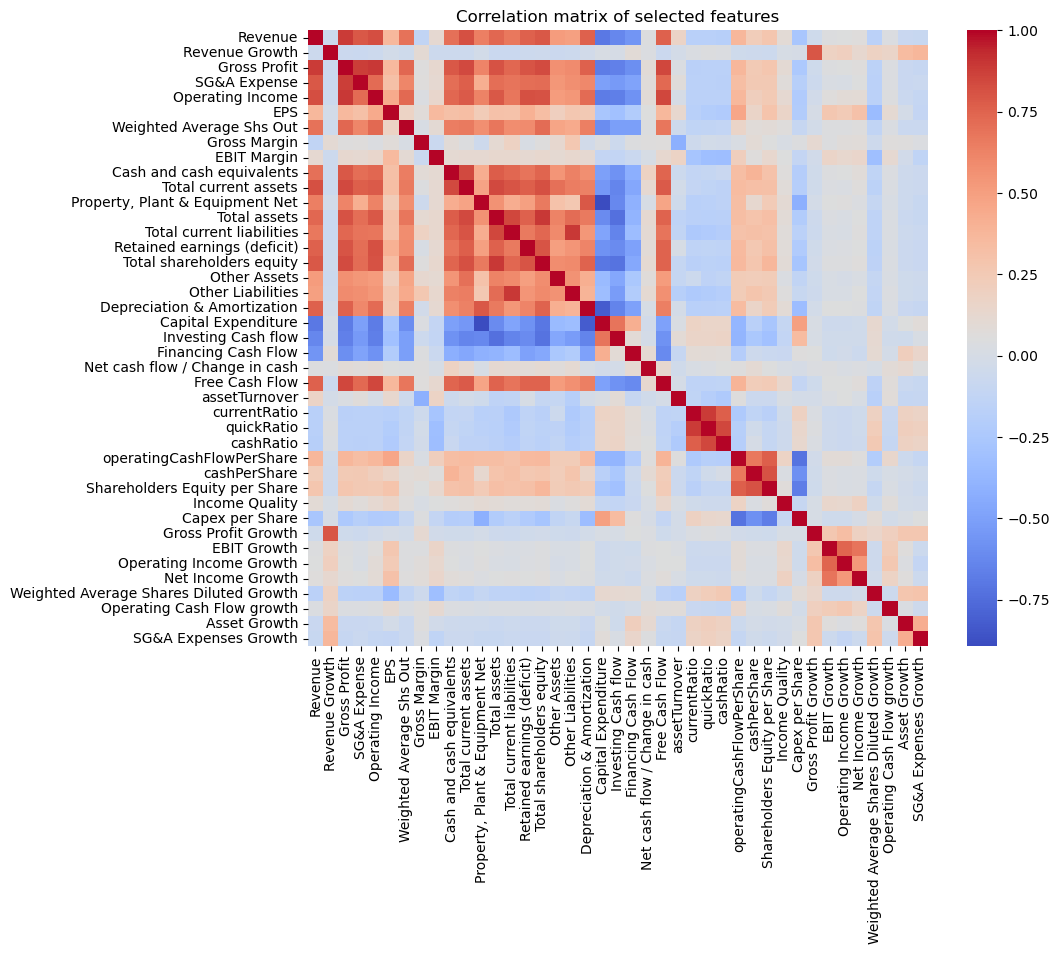

In [412]:
correlation_matrix = df_out[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation matrix of selected features')
plt.show()

In [383]:
selected_features_df = df_out[features]
selected_features_df.head()

,Revenue,Revenue Growth,Gross Profit,SG&A Expense,Operating Income,EPS,Weighted Average Shs Out,Gross Margin,EBIT Margin,Cash and cash equivalents,...,Income Quality,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,Weighted Average Shares Diluted Growth,Operating Cash Flow growth,Asset Growth,SG&A Expenses Growth
CMCSA,3.366963e+10,0.1115,1.596702e+10,6.754875e+09,5.184200e+09,2.5600,1.248565e+09,1.0000,0.1974,3.814000e+09,...,2.0712,-2.7062,0.1115,0.0220,0.0550,-0.484000,-0.0305,0.1428,0.3426,0.1308
KMI,1.414400e+10,0.0320,6.856000e+09,6.010000e+08,3.794000e+09,0.6600,1.248565e+09,0.4847,0.2908,3.280000e+09,...,3.4051,-1.3195,0.0564,0.0405,0.0751,7.155169,-0.0063,0.0961,-0.0024,-0.1265
INTC,3.366963e+10,0.1289,1.596702e+10,6.750000e+09,5.184200e+09,4.5700,1.248565e+09,0.6173,0.3273,3.019000e+09,...,1.3980,-3.2923,0.1187,0.1203,0.2917,1.192800,-0.0277,0.3312,0.0382,-0.0942
MU,3.039100e+10,0.4955,1.596702e+10,8.130000e+08,5.184200e+09,8.7854,1.159811e+09,0.5887,0.4819,5.798060e+09,...,1.2310,-7.7075,1.1208,1.5233,1.5552,1.777600,0.0650,1.1342,0.2275,0.0942
GE,3.366963e+10,0.0285,1.596702e+10,6.754875e+09,-1.799788e+08,-2.6200,1.248565e+09,0.2151,-0.1374,5.798060e+09,...,-0.1862,-0.4066,0.7216,-1.6844,-1.4225,-1.556300,0.0005,-0.2961,-0.1575,0.0308


<a id='knnlogreg'></a>
### K-nn & Logistic Regression
[Return to contents](#contents)

First, let us fit a logistic regression model to predict whether a stock will increase or decrease from revenue alone, just as a baseline model. We will also fit this model on all three datasets we have --- the original one, the SMOTE one, and the undersampled one, for comparison.

In [384]:
X = df_out[features]
y = df_out['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [385]:
# Fit the logistic regression model
logit1 = LogisticRegression()
logit1.fit(X_train[['Revenue']], y_train)

# Store the learned parameters
logit1_beta0 = logit1.intercept_[0]
logit1_beta1 = logit1.coef_[0][0]

# Predict on the train and test sets
y_train_pred = logit1.predict(X_train[['Revenue']])
y_test_pred = logit1.predict(X_test[['Revenue']])

# Calculate and store the train and test classification accuracies
acc_train_logit1 = accuracy_score(y_train, y_train_pred)
acc_test_logit1 = accuracy_score(y_test, y_test_pred)

In [386]:
print("LOGISTIC REGRESSION FOR ORIGINAL DATASET")
print("Learned Parameters:")
print("Intercept: ", logit1_beta0)
print("Coefficient: ", logit1_beta1)
print("\nClassification Accuracies:")
print("Train Accuracy: ", acc_train_logit1)
print("Test Accuracy: ", acc_test_logit1)

LOGISTIC REGRESSION FOR ORIGINAL DATASET
Learned Parameters:
Intercept:  2.6749427288409396e-19
Coefficient:  1.1517404119857235e-10

Classification Accuracies:
Train Accuracy:  0.6945630515229149
Test Accuracy:  0.689419795221843


In [387]:
features_without_capex_quickratio = [feature for feature in features if feature not in ['Capital Expenditure', 'quickRatio']]
X2 = df_out2[features_without_capex_quickratio]
y2 = df_out2['Class']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Fit the logistic regression model
logit1_2 = LogisticRegression()
logit1_2.fit(X_train2[['Revenue']], y_train2)

# Store the learned parameters
logit1_beta0_2 = logit1_2.intercept_[0]
logit1_beta1_2 = logit1_2.coef_[0][0]

# Predict on the train and test sets
y_train_pred2 = logit1_2.predict(X_train2[['Revenue']])
y_test_pred2 = logit1_2.predict(X_test2[['Revenue']])

# Calculate and store the train and test classification accuracies
acc_train_logit1_2 = accuracy_score(y_train2, y_train_pred2)
acc_test_logit1_2 = accuracy_score(y_test2, y_test_pred2)

print("LOGISTIC REGRESSION FOR OVERSAMPLED DATASET")
print("Learned Parameters:")
print("Intercept: ", logit1_beta0_2)
print("Coefficient: ", logit1_beta1_2)
print("\nClassification Accuracies:")
print("Train Accuracy: ", acc_train_logit1_2)
print("Test Accuracy: ", acc_test_logit1_2)

LOGISTIC REGRESSION FOR OVERSAMPLED DATASET
Learned Parameters:
Intercept:  -1.2284368840404984e-20
Coefficient:  4.526647260651638e-11

Classification Accuracies:
Train Accuracy:  0.5005130309870717
Test Accuracy:  0.5365053322395406


In [388]:
features_without_unwanted = [feature for feature in features if feature not in ['Operating Income', 'Gross Profit', 'Other Liabilities', 'Capital Expenditure', 'quickRatio']]
X3 = df_out3[features_without_unwanted]
y3 = df_out3['Class']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

# Fit the logistic regression model
logit1_3 = LogisticRegression()
logit1_3.fit(X_train3[['Revenue']], y_train3)

# Store the learned parameters
logit1_beta0_3 = logit1_3.intercept_[0]
logit1_beta1_3 = logit1_3.coef_[0][0]

# Predict on the train and test sets
y_train_pred3 = logit1_3.predict(X_train3[['Revenue']])
y_test_pred3 = logit1_3.predict(X_test3[['Revenue']])

# Calculate and store the train and test classification accuracies
acc_train_logit1_3 = accuracy_score(y_train3, y_train_pred3)
acc_test_logit1_3 = accuracy_score(y_test3, y_test_pred3)

print("LOGISTIC REGRESSION FOR UNDERSAMPLED DATASET")
print("Learned Parameters:")
print("Intercept: ", logit1_beta0_3)
print("Coefficient: ", logit1_beta1_3)
print("\nClassification Accuracies:")
print("Train Accuracy: ", acc_train_logit1_3)
print("Test Accuracy: ", acc_test_logit1_3)

LOGISTIC REGRESSION FOR UNDERSAMPLED DATASET
Learned Parameters:
Intercept:  -1.2233649397135117e-20
Coefficient:  4.720783021288649e-11

Classification Accuracies:
Train Accuracy:  0.5290292614955876
Test Accuracy:  0.5009276437847866


In [389]:
classification_accuracies = pd.DataFrame({
    'Original': [acc_train_logit1, acc_test_logit1],
    'Oversampling (SMOTE)': [acc_train_logit1_2, acc_test_logit1_2],
    'Random Undersampling': [acc_train_logit1_3, acc_test_logit1_3]
}, index=['Train Accuracy', 'Test Accuracy'])

print(tabulate(classification_accuracies, headers='keys', tablefmt='psql'))

+----------------+------------+------------------------+------------------------+
|                |   Original |   Oversampling (SMOTE) |   Random Undersampling |
|----------------+------------+------------------------+------------------------|
| Train Accuracy |   0.694563 |               0.500513 |               0.529029 |
| Test Accuracy  |   0.68942  |               0.536505 |               0.500928 |
+----------------+------------+------------------------+------------------------+


From these results, we see that both the train and test accuracy are much less accurate for the SMOTE and Random Undersampling dataset than the original dataset, indicating that the altered datasets might be introducing too much noise, or giving too little information. Since the test accuracy of the original model is also doing much better, we decided to not use the oversampled or undersampled dataset and stick with out original dataset.

Next, let us fit a logistic regression model predicting stock increase or decrease with just 'Revenue' and 'EPS'.

In [390]:
# Fit the logistic regression model with 'Revenue' and 'EPS'
logit2 = LogisticRegression()
logit2.fit(X_train[['Revenue', 'EPS']], y_train)

# Store the learned parameters
logit2_beta0 = logit2.intercept_[0]
logit2_beta1, logit2_beta2 = logit2.coef_[0]

# Predict on the train and test sets
y_train_pred2 = logit2.predict(X_train[['Revenue', 'EPS']])
y_test_pred2 = logit2.predict(X_test[['Revenue', 'EPS']])

# Calculate and store the train and test classification accuracies
acc_train_logit2 = accuracy_score(y_train, y_train_pred2)
acc_test_logit2 = accuracy_score(y_test, y_test_pred2)

print("Learned Parameters:")
print("Intercept: ", logit2_beta0)
print("Coefficient for Revenue: ", logit2_beta1)
print("Coefficient for Revenue Growth: ", logit2_beta2)
print("\nClassification Accuracies:")
print("Train Accuracy: ", acc_train_logit2)
print("Test Accuracy: ", acc_test_logit2)

Learned Parameters:
Intercept:  2.6749427288426046e-19
Coefficient for Revenue:  1.1517404119857249e-10
Coefficient for Revenue Growth:  7.1411856671072815e-19

Classification Accuracies:
Train Accuracy:  0.694847708511244
Test Accuracy:  0.7030716723549488


Next, let's fit a full logistic regression model predicting stock increase or decrease with all 16 features.

In [391]:
logit3 = LogisticRegression(max_iter=1000)
logit3.fit(X_train, y_train)

# Store the learned parameters
logit3_beta = logit3.coef_[0]
logit3_intercept = logit3.intercept_[0]

# Predict on the train and test sets
y_train_pred3 = logit3.predict(X_train)
y_test_pred3 = logit3.predict(X_test)

# Calculate and store the train and test classification accuracies
acc_train_logit3 = accuracy_score(y_train, y_train_pred3)
acc_test_logit3 = accuracy_score(y_test, y_test_pred3)

print("Learned Parameters:")
print("Intercept: ", logit3_intercept)
print("Coefficients: ", logit3_beta)
print("\nClassification Accuracies:")
print("Train Accuracy: ", acc_train_logit3)
print("Test Accuracy: ", acc_test_logit3)

Learned Parameters:
Intercept:  8.587470417885868e-17
Coefficients:  [ 2.11649912e-11  4.53800922e-18 -2.46046196e-10  2.65053659e-10
  6.74247233e-10  2.81759925e-16  8.17598325e-10  5.25853156e-17
  7.56372164e-17  2.77939497e-11  4.60628217e-11  2.12933417e-11
 -2.07431601e-11  9.18128295e-12 -7.03577643e-11  8.61268734e-11
 -2.55722700e-12  2.65898432e-10  3.52371679e-10  6.09701599e-10
 -2.34592552e-10  3.66955255e-10  1.07795957e-10  1.86159317e-10
  4.37614167e-17  1.83470807e-16  1.28022630e-16  5.50320635e-17
  2.06314656e-16 -6.48810737e-17  1.09848096e-15  1.31386599e-16
 -6.34924401e-17  7.71723418e-18  2.59854321e-17  1.68422823e-17
  5.83378390e-17 -6.67853884e-18  2.06992884e-17  7.86767973e-18
  7.37740909e-18]

Classification Accuracies:
Train Accuracy:  0.6945630515229149
Test Accuracy:  0.6951080773606371


Next, we scaled our predictors, so that we can weight our parameters similarly in future models.

In [392]:
# Initialize a scaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform both the train and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Next, we fit a well-tuned $k$-NN classification model with main effects of all 16 predictors in it, using 10-fold cross-validation with classification accuracy as the scoring metric. After trying many $k$ values, we plot the training and validation scores of the model at each value of $k$, and then chose the $k$ with the validation accuracy.

In [393]:
ks = [1, 3, 5, 9, 15, 21, 51, 71, 101, 131, 171, 201]
mean_train_scores = []
mean_val_scores = []

for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_train, y_train, cv=10, scoring='accuracy')
    mean_train_scores.append(scores.mean())

    knn_model.fit(X_train, y_train)
    val_score = knn_model.score(X_test, y_test)
    mean_val_scores.append(val_score)

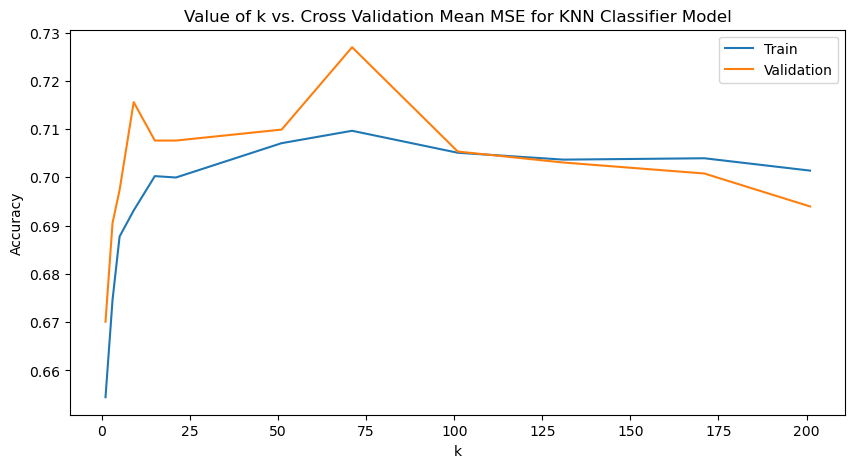

In [394]:
# Plotting the scores
plt.figure(figsize=(10, 5))
plt.plot(ks, mean_train_scores, label='Train')
plt.plot(ks, mean_val_scores, label='Validation')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title("Value of k vs. Cross Validation Mean MSE for KNN Classifier Model")
plt.legend()
plt.show()

In [395]:
# Storing the best k and the classification accuracy on train and test
best_k = ks[mean_val_scores.index(max(mean_val_scores))]
knn_train_acc = max(mean_train_scores)
knn_test_acc = max(mean_val_scores)

In [396]:
print(f"Best k: {best_k}")
print(f"Train accuracy: {knn_train_acc}")
print(f"Test accuracy: {knn_test_acc}")

Best k: 71
Train accuracy: 0.709648569023569
Test accuracy: 0.726962457337884


Full logistic regression model, with scaling.

In [397]:
logit4 = LogisticRegression()
logit4.fit(X_train, y_train)

# Store the learned parameters
logit4_beta = logit3.coef_[0]
logit4_intercept = logit3.intercept_[0]

# Predict on the train and test sets
y_train_pred4 = logit4.predict(X_train)
y_test_pred4 = logit4.predict(X_test)

# Calculate and store the train and test classification accuracies
acc_train_logit4 = accuracy_score(y_train, y_train_pred4)
acc_test_logit4 = accuracy_score(y_test, y_test_pred4)

print("Learned Parameters:")
print("Intercept: ", logit4_intercept)
print("Coefficients: ", logit4_beta)
print("\nClassification Accuracies:")
print("Train Accuracy: ", acc_train_logit4)
print("Test Accuracy: ", acc_test_logit4)

Learned Parameters:
Intercept:  8.587470417885868e-17
Coefficients:  [ 2.11649912e-11  4.53800922e-18 -2.46046196e-10  2.65053659e-10
  6.74247233e-10  2.81759925e-16  8.17598325e-10  5.25853156e-17
  7.56372164e-17  2.77939497e-11  4.60628217e-11  2.12933417e-11
 -2.07431601e-11  9.18128295e-12 -7.03577643e-11  8.61268734e-11
 -2.55722700e-12  2.65898432e-10  3.52371679e-10  6.09701599e-10
 -2.34592552e-10  3.66955255e-10  1.07795957e-10  1.86159317e-10
  4.37614167e-17  1.83470807e-16  1.28022630e-16  5.50320635e-17
  2.06314656e-16 -6.48810737e-17  1.09848096e-15  1.31386599e-16
 -6.34924401e-17  7.71723418e-18  2.59854321e-17  1.68422823e-17
  5.83378390e-17 -6.67853884e-18  2.06992884e-17  7.86767973e-18
  7.37740909e-18]

Classification Accuracies:
Train Accuracy:  0.7147736976942783
Test Accuracy:  0.7087599544937428


In [398]:
# Initialize lists to store results and coefficients
logit_lasso_train_accs = []
logit_lasso_test_accs = []
logit_lasso_coefs = []

# Define the C values to try
Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

# Loop over the C values
for C in Cs:
    # Fit a Lasso-like logistic regression model
    logit_lasso = LogisticRegression(C=C, penalty='l1', solver='saga')
    logit_lasso.fit(X_train, y_train)

    # Predict on the train and test sets
    y_train_pred_lasso = logit_lasso.predict(X_train)
    y_test_pred_lasso = logit_lasso.predict(X_test)

    # Calculate and store the train and test classification accuracies
    logit_lasso_train_acc = accuracy_score(y_train, y_train_pred_lasso)
    logit_lasso_test_acc = accuracy_score(y_test, y_test_pred_lasso)

    # Store the results and coefficients
    logit_lasso_train_accs.append(logit_lasso_train_acc)
    logit_lasso_test_accs.append(logit_lasso_test_acc)
    logit_lasso_coefs.append(logit_lasso.coef_)

# Find the index of the best test accuracy
best_index = np.argmax(logit_lasso_test_accs)

# Print the best results
print("Best Train Accuracy: ", logit_lasso_train_accs[best_index])
print("Best Test Accuracy: ", logit_lasso_test_accs[best_index])
print("Best Coefficients: ", logit_lasso_coefs[best_index])

Best Train Accuracy:  0.7136350697409621
Best Test Accuracy:  0.7178612059158134
Best Coefficients:  [[ 0.16744258 -0.08065529 -0.02661425  0.          0.          0.46664617
   0.          0.09336466  0.1651879   0.00270607  0.13282563  0.
   0.          0.         -0.05100154  0.          0.          0.27953212
   0.          0.06958146 -0.05507839  0.11371554  0.00341785  0.04559155
  -0.24942979 -0.06975859 -0.02966501  0.         -0.01526409 -0.14692738
   0.02730763  0.02032202  0.08170626  0.00806316 -0.05438888  0.
   0.         -0.15216158  0.          0.00968012  0.04806892]]


In [416]:
# Create a DataFrame for non-zero coefficients
non_zero_coefs = pd.DataFrame({'Feature': features, 'Coefficient': best_coefs[0]})
non_zero_coefs = non_zero_coefs[non_zero_coefs['Coefficient'] != 0]

# Sort the DataFrame by coefficient value in ascending order
non_zero_coefs = non_zero_coefs.sort_values('Coefficient', ascending=False)

print("NONZERO COEFFICIENTS")
# Print the DataFrame
print(non_zero_coefs)

NONZERO COEFFICIENTS
                                   Feature  Coefficient
5                                      EPS     0.466646
17                       Other Liabilities     0.279532
0                                  Revenue     0.167443
8                              EBIT Margin     0.165188
10                    Total current assets     0.132826
21                     Financing Cash Flow     0.113716
7                             Gross Margin     0.093365
32                         Capex per Share     0.081706
19                     Capital Expenditure     0.069581
40                    SG&A Expenses Growth     0.048069
23                          Free Cash Flow     0.045592
30           Shareholders Equity per Share     0.027308
31                          Income Quality     0.020322
39                            Asset Growth     0.009680
33                     Gross Profit Growth     0.008063
22          Net cash flow / Change in cash     0.003418
9                Cash and c

In [417]:
# Create a DataFrame for zero coefficients
zero_coefs = pd.DataFrame({'Feature': features, 'Coefficient': best_coefs[0]})
zero_coefs = zero_coefs[zero_coefs['Coefficient'] == 0]

# Sort the DataFrame by coefficient value in ascending order
zero_coefs = zero_coefs.sort_values('Coefficient', ascending=False)

print("ZERO COEFFICIENTS")
# Print the DataFrame
print(zero_coefs)

ZERO COEFFICIENTS
                            Feature  Coefficient
3                      SG&A Expense          0.0
4                  Operating Income          0.0
6          Weighted Average Shs Out          0.0
11  Property, Plant & Equipment Net          0.0
12                     Total assets          0.0
13        Total current liabilities          0.0
15        Total shareholders equity          0.0
16                     Other Assets          0.0
18      Depreciation & Amortization          0.0
27                        cashRatio          0.0
35          Operating Income Growth          0.0
36                Net Income Growth          0.0
38       Operating Cash Flow growth          0.0


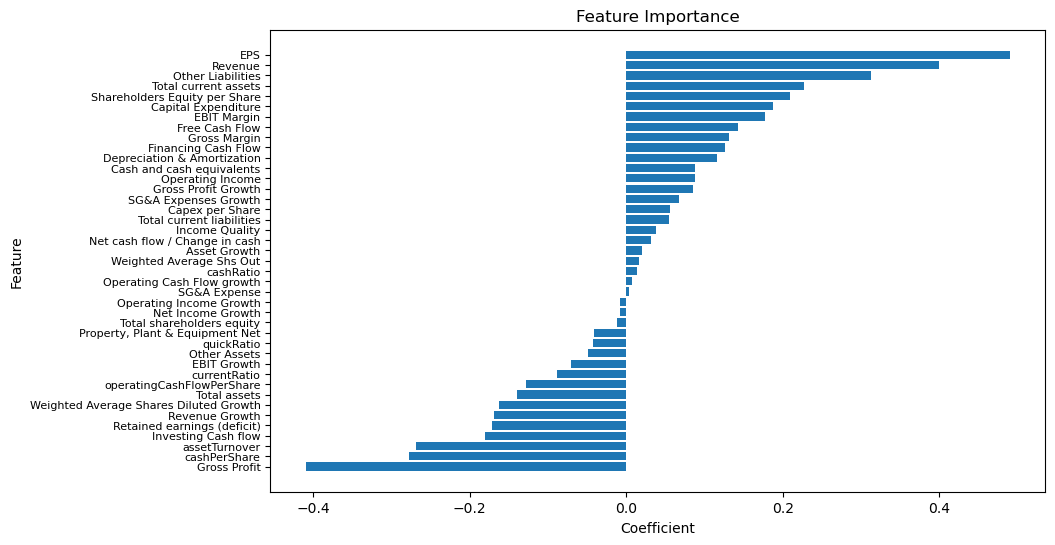

In [414]:
# Get coefficients from the logistic regression model
coefficients = logit_lasso.coef_[0]
coef_df = pd.DataFrame({'feature': features, 'coefficient': coefficients})
coef_df = coef_df.sort_values('coefficient', ascending=False)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_df['feature'], coef_df['coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.yticks(fontsize=8)  # Adjust the y-ticks to be slightly farther apart
plt.show()

In [402]:
# Store all the train and test accuracies as well as the model description in a dataframe
model_results = pd.DataFrame({
    'Model': ['Logistic Regression (just Revenue)', 'Logistic Regression (Revenue + EPS)', 'Logistic Regression (all features, no scaling)', 'Logistic Regression (all features, scaled)', 'Logistic Regression with Lasso', 'KNN (k=71)'],
    'Train Accuracy': [acc_train_logit1, acc_train_logit2, acc_train_logit3, acc_train_logit4, logit_lasso_train_accs[best_index], knn_train_acc],
    'Test Accuracy': [acc_test_logit1, acc_test_logit2, acc_test_logit3, acc_test_logit4, logit_lasso_test_accs[best_index], knn_test_acc]
})

model_results

,Model,Train Accuracy,Test Accuracy
0,Logistic Regression (just Revenue),0.694563,0.689420
1,Logistic Regression (Revenue + EPS),0.694848,0.703072
2,"Logistic Regression (all features, no scaling)",0.694563,0.695108
3,"Logistic Regression (all features, scaled)",0.714774,0.708760
4,Logistic Regression with Lasso,0.713635,0.717861
5,KNN (k=71),0.709649,0.726962


After training logistic regression models on various parameters, with scaled and unscaled features, and with lasso regression, we see that the best performing logistic regression models (based on test accuracy), is the logistic regression model on all scaled features with lasso regulation. We see that the logistic regression model based on just revenue and EPS and the logistic regression model based on all scaled features also did well. From the lasso regularization, we see that Revenue, Total shareholders equity, Free Cash Flow, Gross Profit growth, and Operating Cash Flow growth came out with coefficients of 0, indicating that they might be less significant as predictors than the other features. Additionally, from plotting the coefficients of both the logistic regression and the logistic regression with lasso, we see that EPS and Total current liabilities have the greatest magnitude of coefficients out of all of the features, which may indicate that those two features are the best predictors of the classification of a stock. 

We also ran one k-nn model on the features, choosing the k that yielded the highest validation score, which was k=71. This k-nn model actually performed better than all of the logistic regression models in terms of test accuracy, which may be because k-nn models can capture complex decision boundaries. However, it was still important to run the logistic regression model, as it has more interpretable coefficients that can tell us the predicting power of each feature.

# Decision Trees

First, we fit a decision tree classifier to the data with 20 different depths, choosing the best performing depth as our result.

In [403]:
train_scores = []
cvmeans = []
cvstds = []

# Fit a decision tree to the entire training set for each depth from 1 to 20
for depth in range(1, 21):
    dt = DecisionTreeClassifier(max_depth=depth, random_state=0)
    dt.fit(X_train, y_train)

    # Evaluate on the entire training set
    train_scores.append(dt.score(X_train, y_train))

    # Perform 5-fold cross-validation with the entire training set
    cv_scores = cross_val_score(dt, X_train, y_train, cv=5)
    cvmeans.append(cv_scores.mean())
    cvstds.append(cv_scores.std())

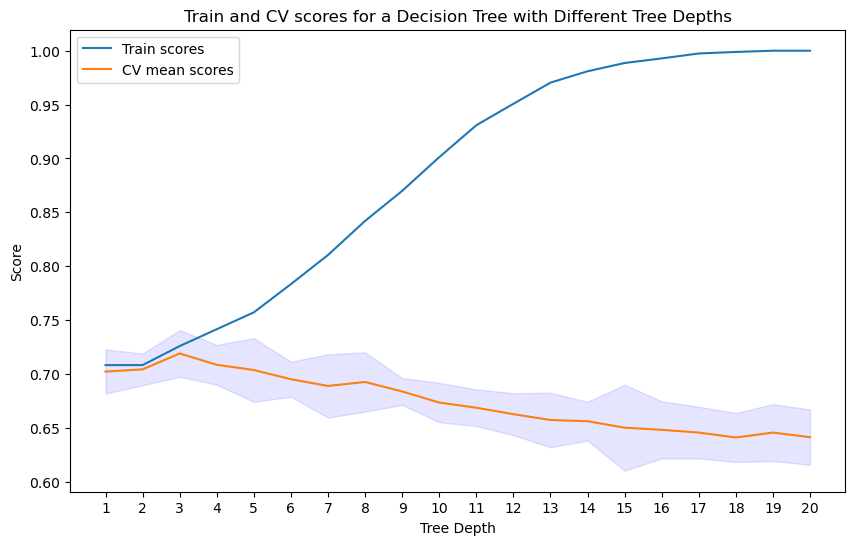

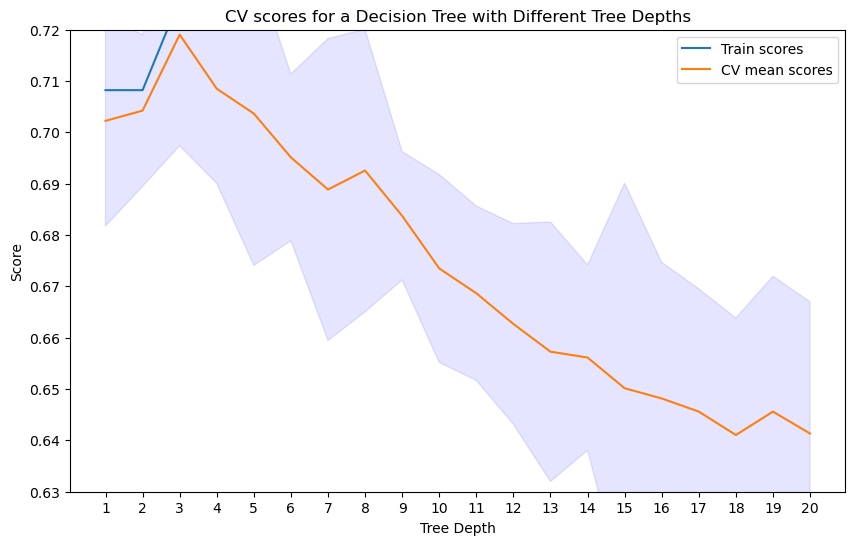

In [404]:
# Create a range for the depths
depths = range(1, 21)

# Plot 1: All scores
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Train scores')
plt.plot(depths, cvmeans, label='CV mean scores')
plt.fill_between(depths, np.array(cvmeans) - 2*np.array(cvstds), np.array(cvmeans) + 2*np.array(cvstds), color='b', alpha=0.1)
plt.xticks(np.arange(1, 21, step=1))  # Set x-ticks from 1 to 20
plt.legend()
plt.xlabel('Tree Depth')
plt.ylabel('Score')
plt.title('Train and CV scores for a Decision Tree with Different Tree Depths')
plt.show()

# Plot 2: Focus on validation performance
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Train scores')
plt.plot(depths, cvmeans, label='CV mean scores')
plt.fill_between(depths, np.array(cvmeans) - 2*np.array(cvstds), np.array(cvmeans) + 2*np.array(cvstds), color='b', alpha=0.1)
plt.ylim(0.63, 0.72)
plt.xticks(np.arange(1, 21, step=1))  # Set x-ticks from 1 to 20
plt.legend()
plt.xlabel('Tree Depth')
plt.ylabel('Score')
plt.title('CV scores for a Decision Tree with Different Tree Depths')
plt.show()

In [405]:
best_cv_depth = np.argmax(cvmeans) + 1  # Add 1 because depths start from 1

# Justification: The best depth is the one that maximizes the mean cross-validation score.

# Fit a new decision tree on the entire training data using the best depth
best_cv_tree = DecisionTreeClassifier(max_depth=best_cv_depth, random_state=0)
best_cv_tree.fit(X_train, y_train)

# Store the train and test accuracies
best_cv_tree_train_score = best_cv_tree.score(X_train, y_train)
best_cv_tree_test_score = best_cv_tree.score(X_test, y_test)

# Print the best depth and accuracies
print(f"Best depth: {best_cv_depth}")
print(f"Train accuracy: {best_cv_tree_train_score}")
print(f"Test accuracy: {best_cv_tree_test_score}")

Best depth: 3
Train accuracy: 0.7258753202391118
Test accuracy: 0.7076222980659841


We see that a tree depth of 4 yields the best test accuracy, which makes sense. 

Next, we used bagging on the most overfit depth to help correct the overfitting

In [406]:
# Create a BaggingClassifier with a deep DecisionTreeClassifier
bagging_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=17, random_state=0), n_estimators=100, random_state=0)
bagging_clf.fit(X_train, y_train)

# Store the train and test accuracies
bagging_train_score = bagging_clf.score(X_train, y_train)
bagging_test_score = bagging_clf.score(X_test, y_test)

# Print the accuracies
print(f"Train accuracy: {bagging_train_score}")
print(f"Test accuracy: {bagging_test_score}")

Train accuracy: 0.9974380871050385
Test accuracy: 0.7235494880546075


We also fit a random forest classifier on the data.

In [407]:
# Create a RandomForestClassifier
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=0)
random_forest_clf.fit(X_train, y_train)

# Store the train and test accuracies
random_forest_train_score = random_forest_clf.score(X_train, y_train)
random_forest_test_score = random_forest_clf.score(X_test, y_test)

# Print the accuracies
print(f"Train accuracy: {random_forest_train_score}")
print(f"Test accuracy: {random_forest_test_score}")

Train accuracy: 0.999715343011671
Test accuracy: 0.7337883959044369


And a gradient boosting classifier.

In [408]:
# Create a GradientBoostingClassifier
boosting_clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
boosting_clf.fit(X_train, y_train)

# Store the train and test accuracies
boosting_train_score = boosting_clf.score(X_train, y_train)
boosting_test_score = boosting_clf.score(X_test, y_test)

# Print the accuracies
print(f"Train accuracy: {boosting_train_score}")
print(f"Test accuracy: {boosting_test_score}")

Train accuracy: 0.8334756618274979
Test accuracy: 0.7337883959044369


In [409]:
# Create a DataFrame to store the accuracies
accuracies = pd.DataFrame({
    'Model': ['Best CV Depth DecisionTreeClassifier', 'BaggingClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier'],
    'Train Accuracy': [best_cv_tree_train_score, bagging_train_score, random_forest_train_score, boosting_train_score],
    'Test Accuracy': [best_cv_tree_test_score, bagging_test_score, random_forest_test_score, boosting_test_score]
})

accuracies

,Model,Train Accuracy,Test Accuracy
0,Best CV Depth DecisionTreeClassifier,0.725875,0.707622
1,BaggingClassifier,0.997438,0.723549
2,RandomForestClassifier,0.999715,0.733788
3,GradientBoostingClassifier,0.833476,0.733788


The RandomForestClassifier model performed the best with a train accuracy of 1.000 and a test accuracy of 0.726962. This might be due to the fact that RandomForestClassifier is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes of the individual trees. This makes it a very powerful model capable of handling a large dataset with high dimensionality.

The GradientBoostingClassifier also performed well with a train accuracy of 0.816966 and a test accuracy of 0.718999. This model builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. However, it can be more sensitive to overfitting if the data is noisy, which in this case, it is.

The BaggingClassifier had a very high train accuracy of 0.998007 but a lower test accuracy of 0.717861. This indicates that the model may have overfit the training data. BaggingClassifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions to form a final prediction. This can lead to high variance if the base classifier is not robust enough.

The Best CV Depth DecisionTreeClassifier had the lowest train and test accuracies of 0.737262 and 0.697383 respectively. Decision trees are simple to understand and interpret, but they can easily overfit the data and have poor prediction performance if the depth of the tree is not properly tuned.

In the future, we may try running the random forest classifier on more features to see the result.

# Neural Networks

Finally, we trained neural networks on all of the original features (after accounting for missingness and outliers). Since the models took much longer to train, we added the code in separate files to the assignment.

We trained the following models:
- model_bagging.py: neural network CV w/ bagging
- model.py: neural network CV (with optional small parameters for shorter training time)
- model_parallel.py: neural network CV (with parallel computing to speed up the process)
- model_RF.py: neural network random forests CV
- svm.py: SVM CV


## General Model

Our general model.py file includes the base neural network we tried to implement. The file includes a test implementation of GridSearchCV with a neural network (with parameters hidden sizes and droupout rate). The next section of code includes a much more extensive test, with these parameters tested:

In [410]:
'''
param_grid = {
    'lr': [0.01, 0.1, 0.001],
    'max_epochs': [10, 20, 30],
    'module__dropout_rate': [0.3, 0.5, 0.7],
    'module__hidden_sizes': [
        [64, 32],
        [128, 64, 32],
        [32, 32, 32],
        [256, 128, 64, 32], 
        [64, 64, 64],       
    ],
    'optimizer': [optim.Adam, optim.SGD, optim.RMSprop],
    'batch_size': [16, 32, 64],
    'module__num_layers': [2, 3, 4],
    'optimizer__weight_decay': [0.01, 0.001, 0.0001],
    'optimizer__momentum': [0.9, 0.95, 0.99],
    'module__activation_func': [F.relu, F.leaky_relu, F.elu, F.sigmoid],
}'''

"\nparam_grid = {\n    'lr': [0.01, 0.1, 0.001],\n    'max_epochs': [10, 20, 30],\n    'module__dropout_rate': [0.3, 0.5, 0.7],\n    'module__hidden_sizes': [\n        [64, 32],\n        [128, 64, 32],\n        [32, 32, 32],\n        [256, 128, 64, 32], \n        [64, 64, 64],       \n    ],\n    'optimizer': [optim.Adam, optim.SGD, optim.RMSprop],\n    'batch_size': [16, 32, 64],\n    'module__num_layers': [2, 3, 4],\n    'optimizer__weight_decay': [0.01, 0.001, 0.0001],\n    'optimizer__momentum': [0.9, 0.95, 0.99],\n    'module__activation_func': [F.relu, F.leaky_relu, F.elu, F.sigmoid],\n}"

With all these parameters, there are over 130,000 models that can be created. The best five-fold CV model had the following parameters, with a test accuracy of 0.7235, outperformed only by the random forest.
- Batch Size: 32, 
- Learning Rate: 0.01,
- Max Epochs: 20, 
- Dropout Rate: 0.3, 
- Hidden Sizes: [64, 32], 
- Number of Layers: 3, 
- Optimizer: <class 'torch.optim.sgd.SGD'>

We also modified the code in model_parallel.py to take advantage of parallel processing to increase the training speed.

## Neural Networks with Bagging

Next, we decided to try bagging in Neural Networks. We used the same approach used in class, but with Neural Networks. The code allows the user to enter a list of numbers of models, and then for each number, it runs a bagging model and returns the test training.

After running this on 5, 10, 20, 30, 40, and 50 models, here was our result:

| Number of Models      | Test Accuracy |
| ----------- | ----------- |
| 5      | 0.6997       |
| 10   | 0.7144        |
| 20   | 0.7133        |
| 30   | 0.7076        |
| 40   | 0.7110        |
| 50   | 0.7110        |
| 60   | 0.7144        |


## Neural Networks with Random Forests

Next, we implemented random forests in Neural Networks as well. We built onto the approach used in class. The code interface works similar to that above, with the user being able to enter their own list of numbers.

We trained RFs with 5, 10, 15, and 20 neural networks. Here are our results:

| Number of Models      | Test Accuracy |
| ----------- | ----------- |
| 5      | 0.7042       |
| 10   | 0.7224        |
| 15   | 0.7144        |
| 20   | 0.7144        |


## Note on Bagging and Random Forests

Note that we no longer used CV Grid Search here. In the future, it might be better if we introduce CV validation Grid Search in each training step. This would likely increase the performance of the model!

## Reflection

The results came to around 0.70-0.72 accuracy for each of these models, with the standard neural network CV with 20 epochs performing the best at an accuracy of 0.72.

Neural networks might be a good fit for this problem due to their ability to model complex, non-linear relationships, which are common in financial data. They can capture interactions between different financial indicators that simpler models might miss. Additionally, neural networks can learn to recognize patterns in the data, which can be particularly useful when predicting financial trends. However, they can be computationally intensive and may require a large amount of data to train effectively.

Despite their potential, the neural networks might not be performing as well in this case due to several reasons. First, the complexity of these models can lead to overfitting, especially if the network architecture is not properly designed. Second, the training process of neural networks is computationally intensive and was very slow. This can be a problem if the dataset is large or if the model needs to be retrained frequently. Lastly, neural networks require a large amount of data to train effectively. If the dataset is not large enough, the models may not be able to learn the underlying patterns in the data, leading to poor performance.

Next, we will continue to explore these models and fine tune them to better performance.

## Support Vector Machine

We also took a crack at an SVM model! The impelmentation was very similar to our base Neural Network CV Grid Search; we tested for these parameters:

In [411]:
'''
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],  # Only for poly kernel
    'coef0': [0.0, 1.0, 2.0],  # Only for poly and sigmoid kernels
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4, 1e-5],
    'class_weight': [None, 'balanced'],
    'decision_function_shape': ['ovo', 'ovr'],
}
'''

"\nparam_grid = {\n    'C': [0.1, 1, 10],\n    'gamma': [0.01, 0.1, 1],\n    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],\n    'degree': [2, 3, 4],  # Only for poly kernel\n    'coef0': [0.0, 1.0, 2.0],  # Only for poly and sigmoid kernels\n    'shrinking': [True, False],\n    'tol': [1e-3, 1e-4, 1e-5],\n    'class_weight': [None, 'balanced'],\n    'decision_function_shape': ['ovo', 'ovr'],\n}\n"

This was over 33,000 models! We found that the best model had a test accuracy of 0.7076. The best parameters were:

- C: 1
- Class Weight: None
- Coefficient 0: 0.0
- Decision Function Shape: ovo
- Degree: 2
- Gamma: 0.01
- Kernel: rbf
- Shhrinking: True
- Tol: 0.001

In the next steps, we will finetune better and hopefully find better models!